In [1]:
import pandas as pd
import numpy as np

import requests
import openpyxl as xl
import time
import json

import folium
import re

#import geopandas as gpd
from matplotlib import pyplot as plt # 그래프 그리는 용도
import seaborn as sns

%matplotlib inline

from pathlib import Path

from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from pandas.plotting import parallel_coordinates

from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.filterwarnings(action='ignore') # 경고메세지 숨기기

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# 자치구 상관관계 확인

In [89]:
df = pd.read_excel("fin_dataset_goo.xlsx")
df.head()

,goo_nm,goo_area,sum_pop,sum_hh,one_hh,one_ratio,cc_value,count_zero,count_market,count_univ,count_bus,count_station,sum_bus,sum_station,sum_order,sum_waste
0,강남구,39.51,544055,208833,58663,0.107825,457,0,46,1,552,22,102636377,107653238,68999,5556.9
1,강동구,24.58,463998,177148,39486,0.085100,414,3,21,0,396,10,34783737,34193728,50316,2766.3
2,강북구,23.60,311569,129805,32979,0.105848,320,0,17,0,412,11,57437812,25855961,45685,838.3
3,강서구,41.44,585901,244097,69879,0.119268,548,1,22,2,619,16,55236175,43691763,86172,4928.8
4,관악구,29.57,509803,248959,115556,0.226668,460,2,24,1,490,6,89607537,61049638,129233,1631.4


In [90]:
df.columns

Index(['goo_nm', 'goo_area', 'sum_pop', 'sum_hh', 'one_hh', 'one_ratio',
       'cc_value', 'count_zero', 'count_market', 'count_univ', 'count_bus',
       'count_station', 'sum_bus', 'sum_station', 'sum_order', 'sum_waste'],
      dtype='object')

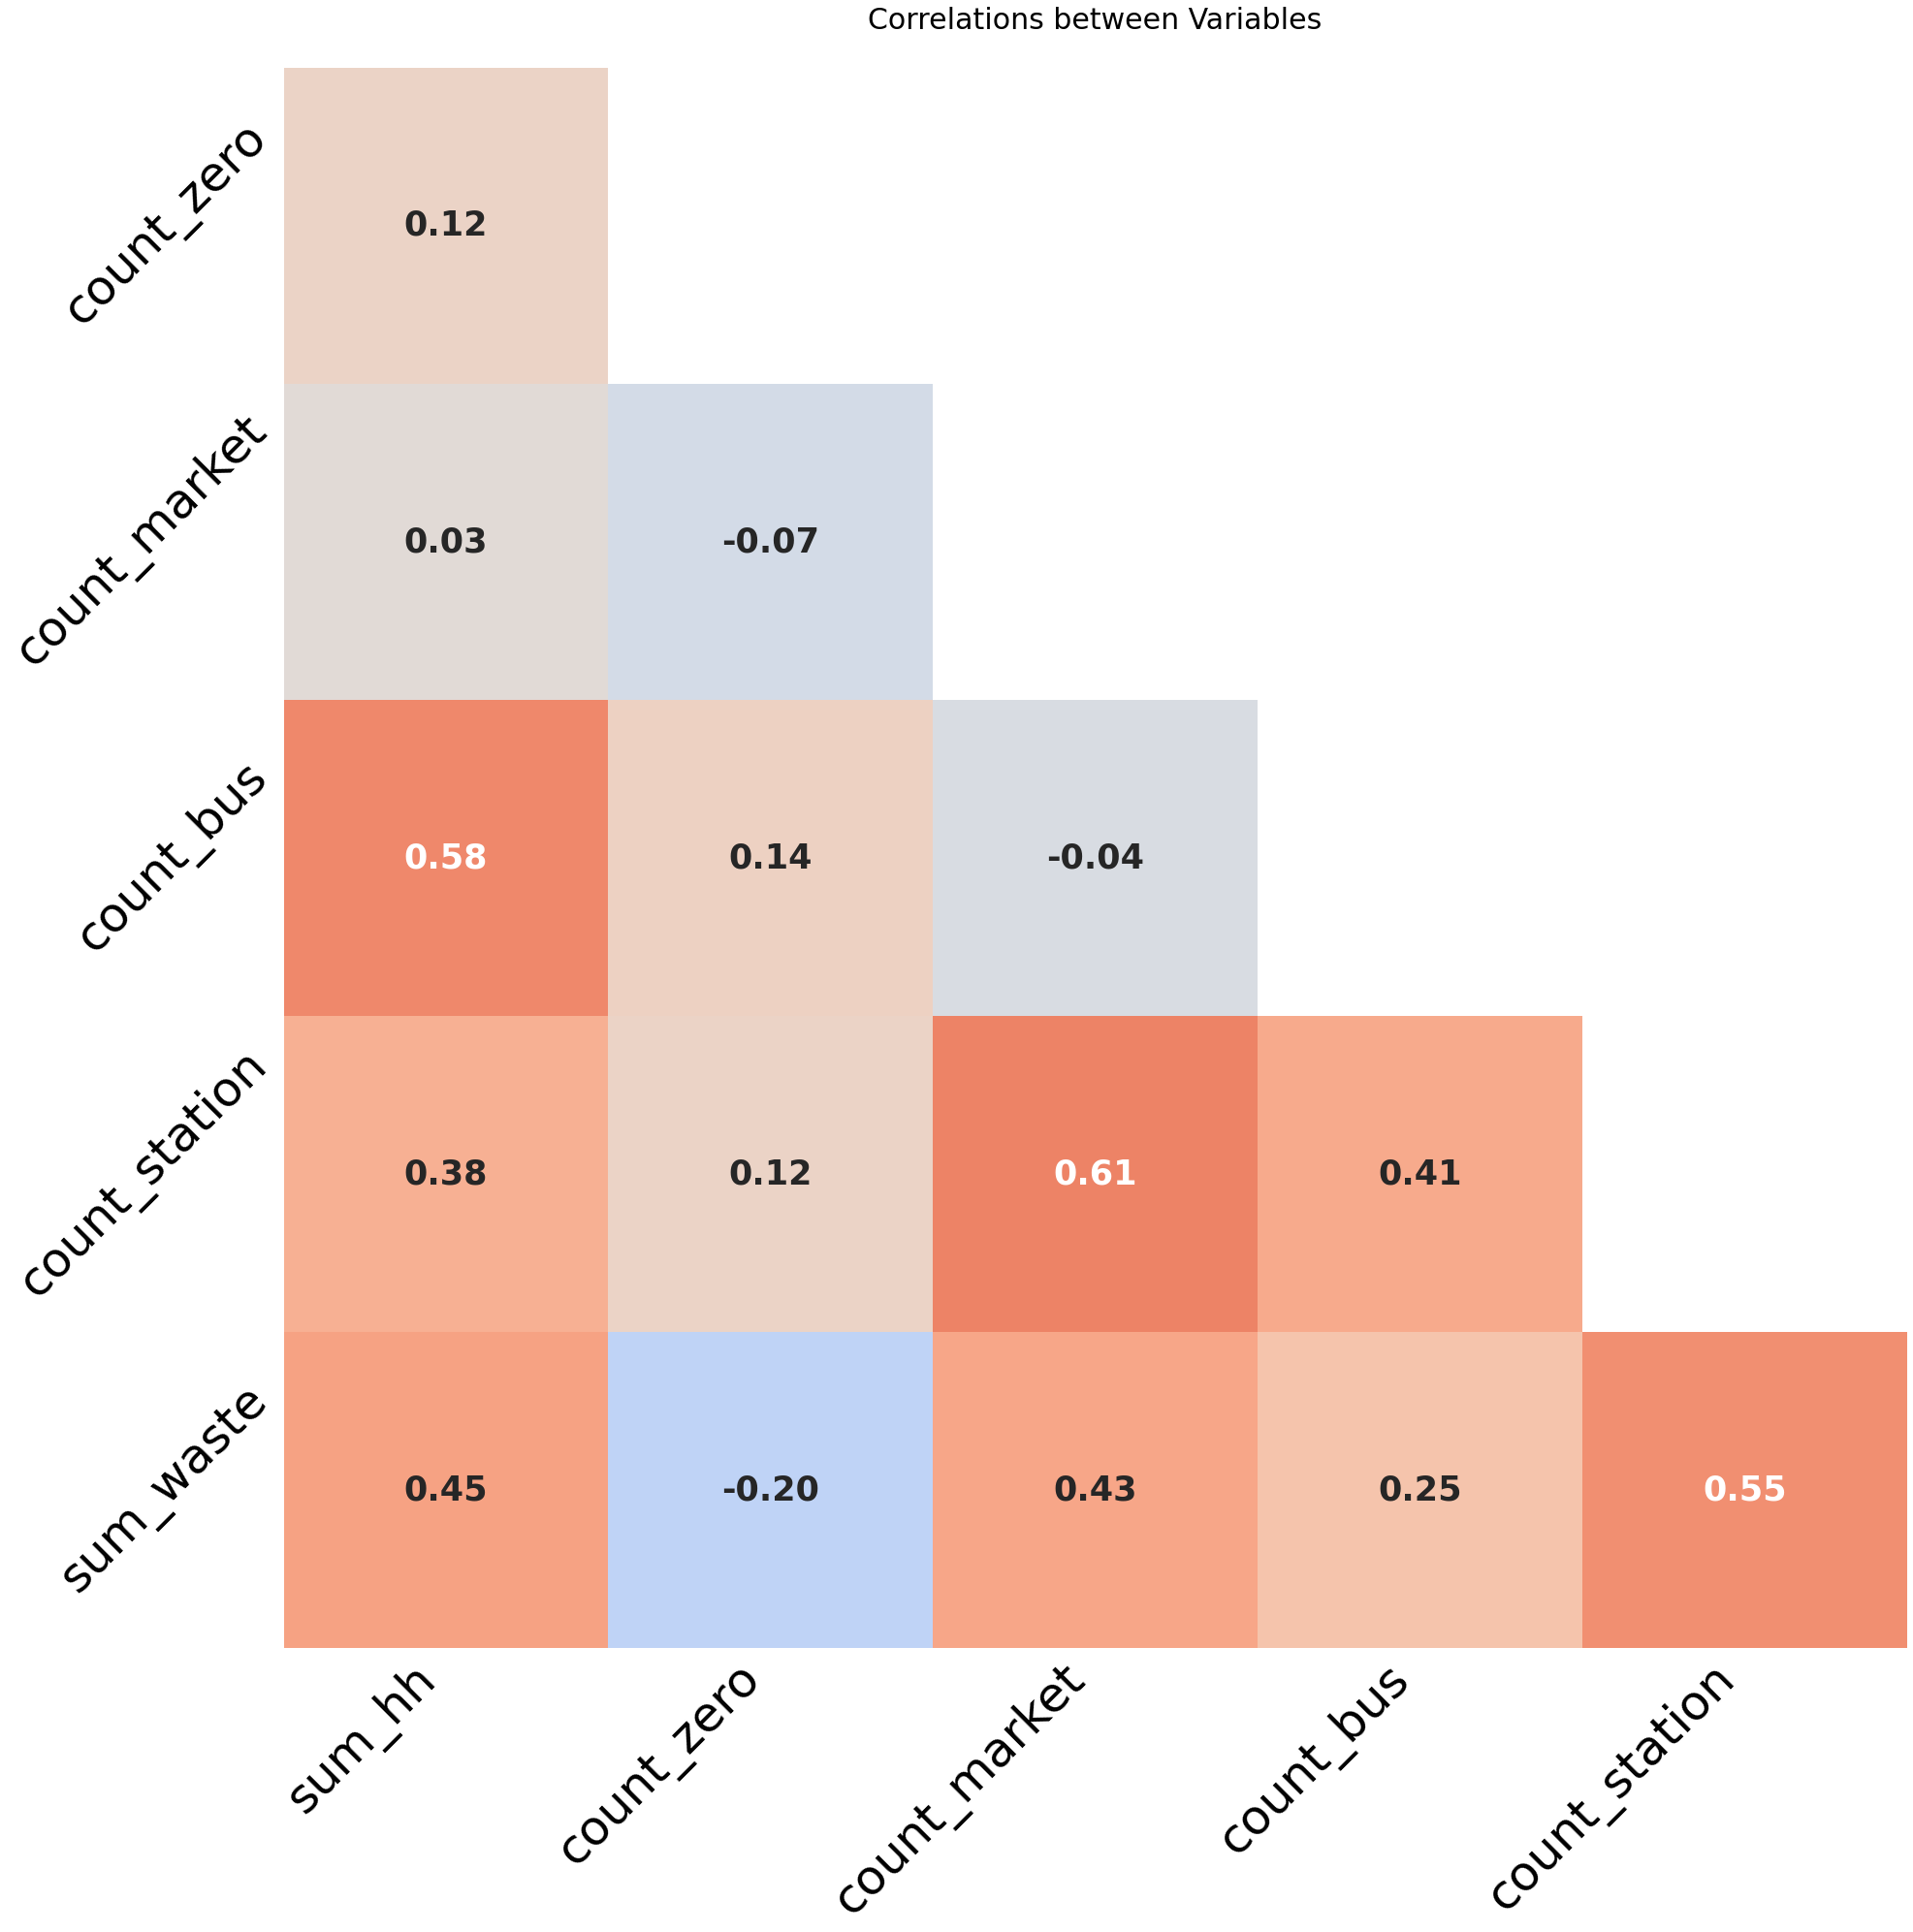

In [4]:
corr=df[['sum_hh', 'count_zero', 'count_market', 'count_bus', 'count_station', 'sum_waste']].corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(30,30))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':35,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=50)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, fontsize=50)
plt.title('Correlations between Variables\n', fontsize=30)
fig.show()

# 행정동 상관관계 확인

In [5]:
df2 = pd.read_excel("fin_dataset_dong.xlsx")
df2.head()

,gd_nm,goo_nm,dong_ID,dong_nm,dong_area,sum_pop,sum_hh,one_hh,cc_value,count_zero,count_market,count_univ,count_bus,count_station,sum_bus,sum_station,sum_order,sum_waste,y,x
0,송파구 가락1동,송파구,11710631,가락1동,1.46,27876,9534,1045,0,0,1,0,10,2,2605376,6434890,73694,4271.9,37.496537,127.105726
1,송파구 가락2동,송파구,11710632,가락2동,1.34,33204,11482,1892,10,0,2,0,22,2,2181971,3449427,73694,4271.9,37.498639,127.126488
2,송파구 가락본동,송파구,11710620,가락본동,0.96,27368,10576,2642,30,1,1,0,25,0,3081377,0,73694,4271.9,37.495585,127.121830
3,구로구 가리봉동,구로구,11530595,가리봉동,0.40,14263,4901,2244,10,0,0,0,10,0,2235038,0,50971,1278.5,37.482704,126.888019
4,금천구 가산동,금천구,11545510,가산동,2.52,25973,14124,8016,30,0,6,0,105,2,10824582,14509425,42334,3794.8,37.476681,126.883767


In [6]:
df2.columns

Index(['gd_nm', 'goo_nm', 'dong_ID', 'dong_nm', 'dong_area', 'sum_pop',
       'sum_hh', 'one_hh', 'cc_value', 'count_zero', 'count_market',
       'count_univ', 'count_bus', 'count_station', 'sum_bus', 'sum_station',
       'sum_order', 'sum_waste', 'y', 'x'],
      dtype='object')

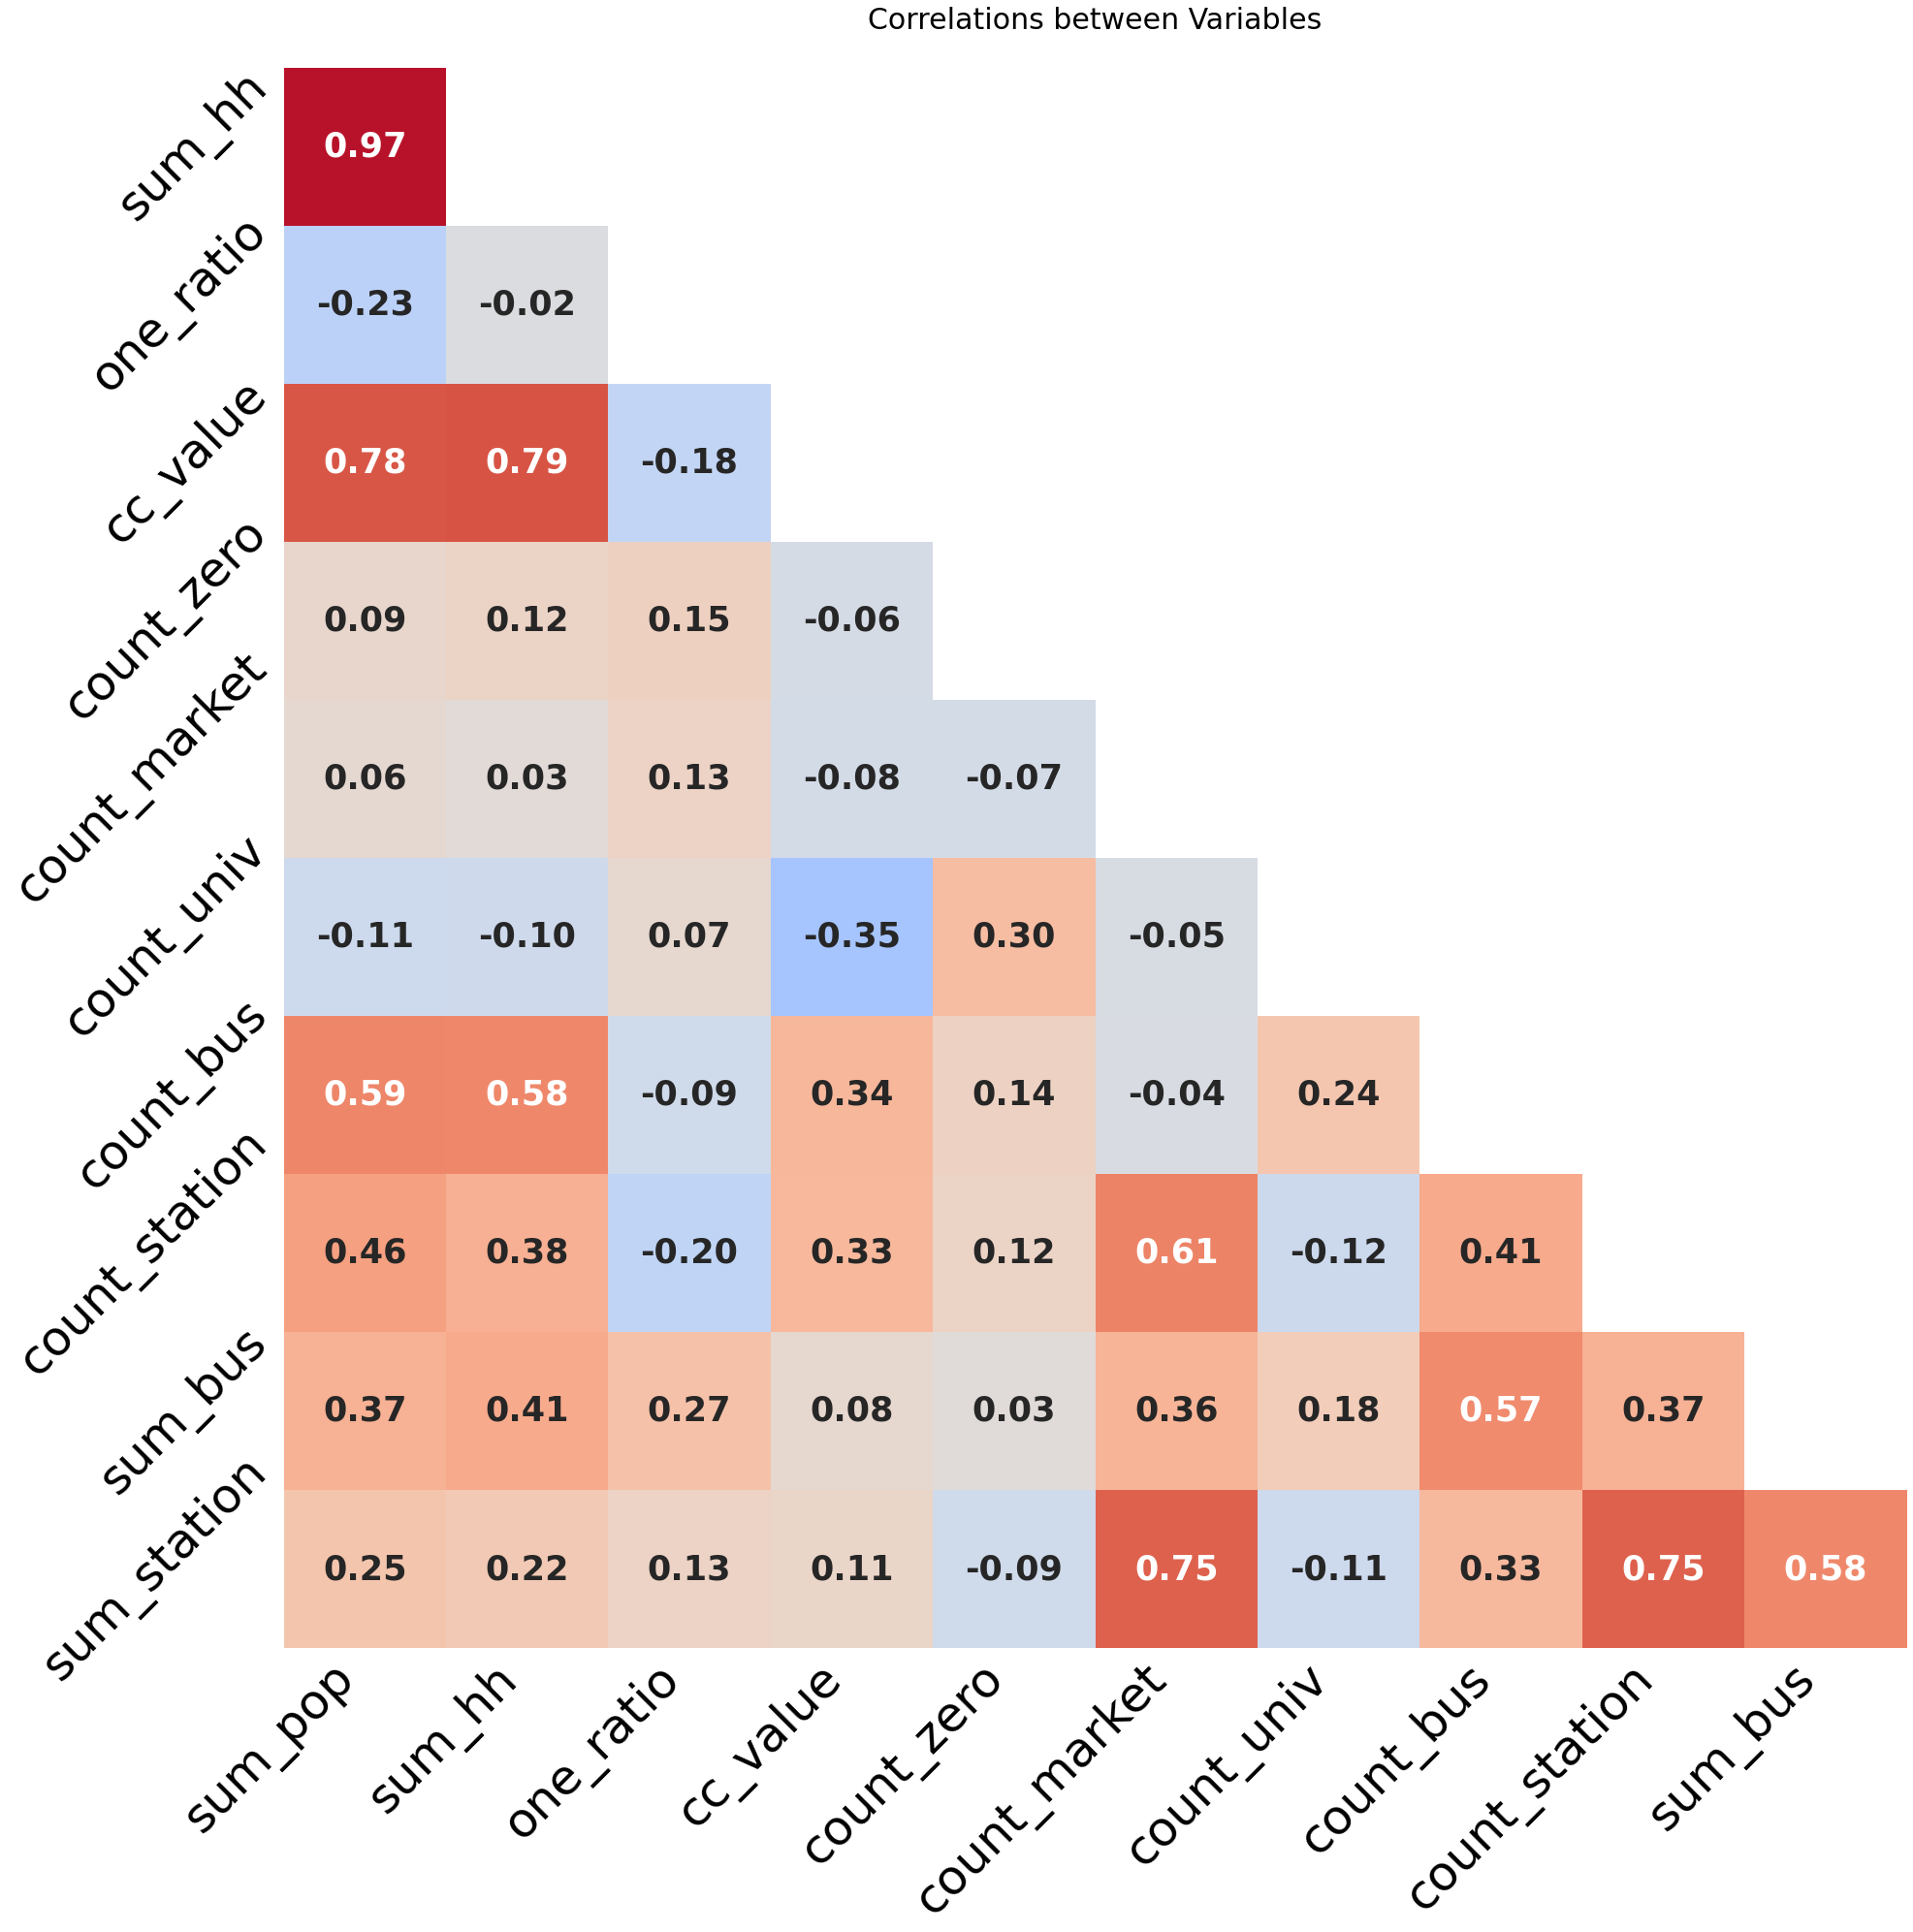

In [8]:
corr=df[['sum_pop',
       'sum_hh', 'one_ratio', 'cc_value', 'count_zero', 'count_market',
       'count_univ', 'count_bus', 'count_station', 'sum_bus', 'sum_station']].corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(30,30))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':35,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=50)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, fontsize=50)
plt.title('Correlations between Variables\n', fontsize=30)
fig.show()

# 구 클러스터링
# 계층적 군집 분석
#### scale : minmax, standard, roburst
#### method : single, complete, average, centroid, ward linkage

In [127]:
goo_df = df.copy()
goo_df = goo_df[["goo_nm","sum_hh", "count_zero", "count_market", "count_bus", "count_station", "sum_waste"]]
goo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   goo_nm         25 non-null     object 
 1   sum_hh         25 non-null     int64  
 2   count_zero     25 non-null     int64  
 3   count_market   25 non-null     int64  
 4   count_bus      25 non-null     int64  
 5   count_station  25 non-null     int64  
 6   sum_waste      25 non-null     float64
dtypes: float64(1), int64(5), object(1)
memory usage: 1.5+ KB


In [128]:
goo_df.set_index("goo_nm",inplace=True) # 지역구 이름 인덱싱 -> 정규화하기 위함

In [129]:
goo_df

,sum_hh,count_zero,count_market,count_bus,count_station,sum_waste
goo_nm,,,,,,
강남구,208833,0,46,552,22,5556.9
강동구,177148,3,21,396,10,2766.3
강북구,129805,0,17,412,11,838.3
강서구,244097,1,22,619,16,4928.8
관악구,248959,2,24,490,6,1631.4
광진구,152090,1,23,292,9,1584.9
구로구,164083,0,24,480,10,1278.5
금천구,103432,0,20,354,3,3794.8
노원구,202695,1,19,535,12,1108.3


# 1) minmax

In [130]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(goo_df)
goo_norm = pd.DataFrame(data, index = list(goo_df.index))

1-1 single
<br>
1-2 complete
<br>
1-3 average
<br>
1-4 centroid
<br>
1-5 ward
#### 1-1 single

In [131]:
g_n = goo_norm.copy()

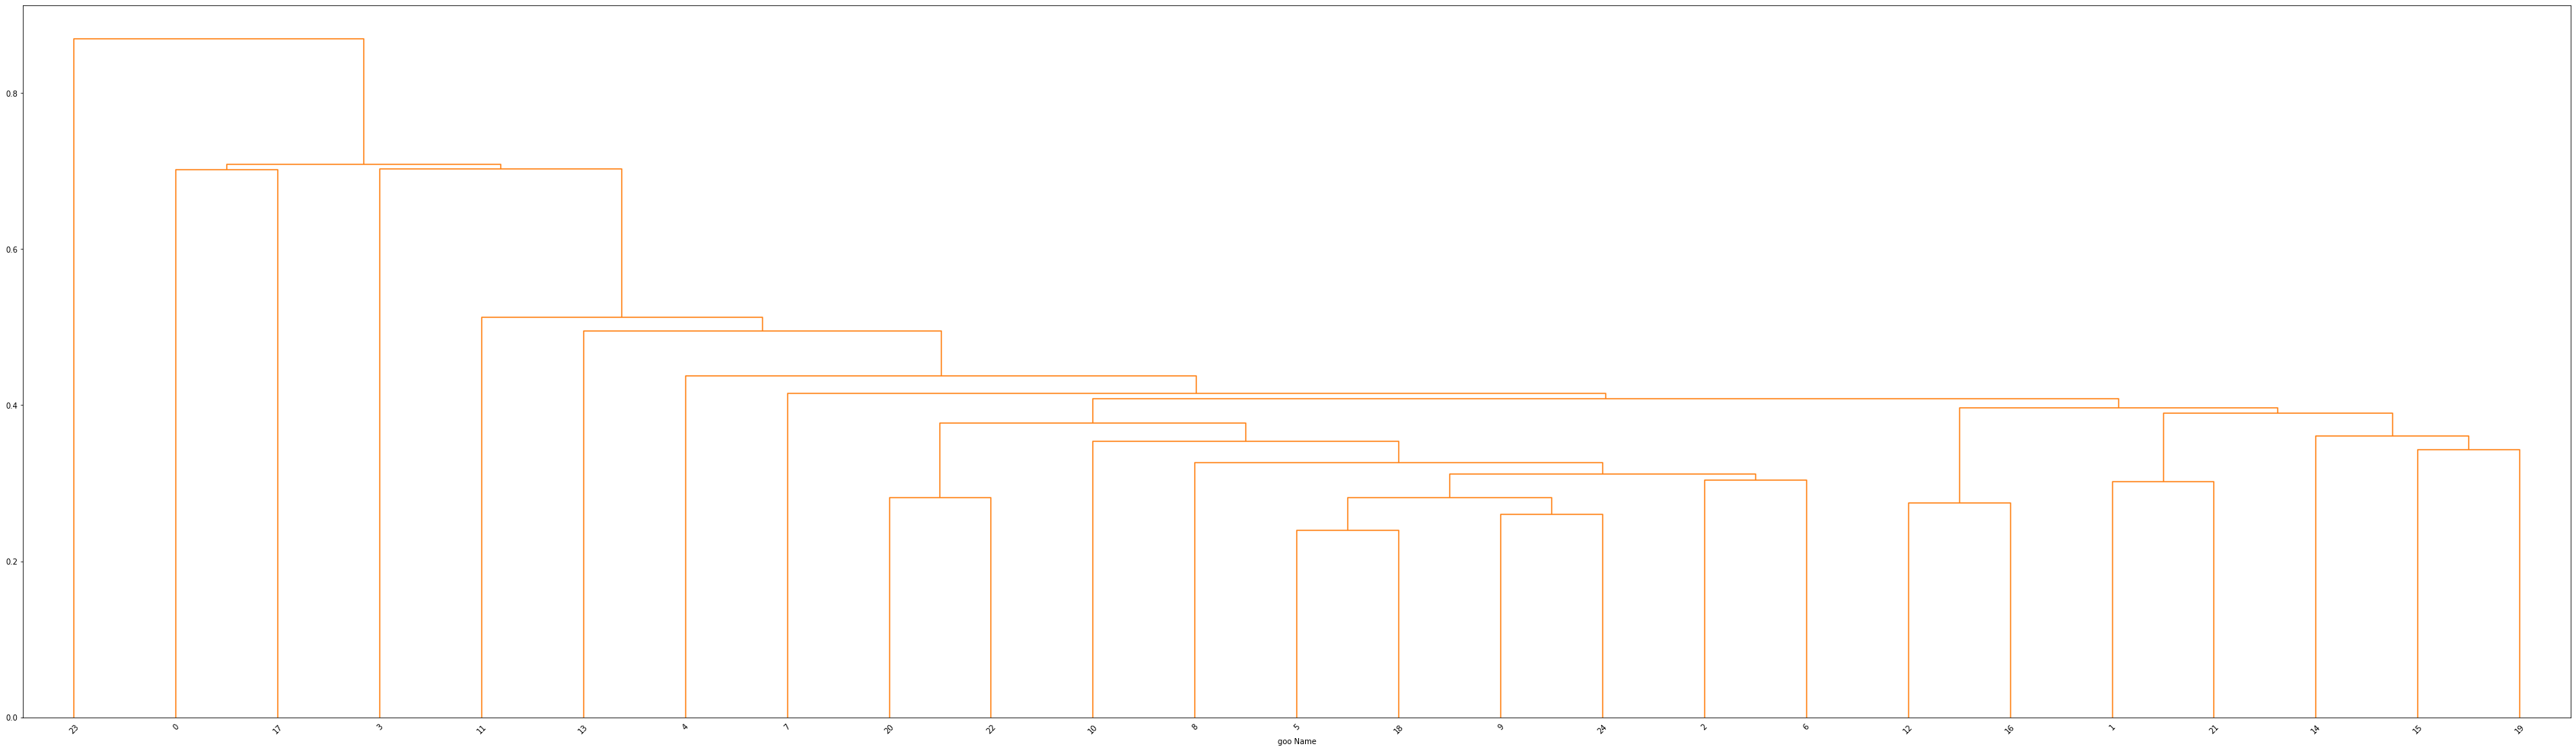

In [132]:
# 덴드로그램

Z = linkage(g_n, method='single') # single / complete / average 
# complete 어느 정도 수준까지 같은 군집으로 볼 것인가

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

# 계층적 군집화를 실행하는 덴드로그램
plt.title('')  
plt.xlabel("goo Name")

# 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
dendrogram(Z, color_threshold = 4) 
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강남구, 송파구
2 :  강동구, 강북구, 강서구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중랑구
3 :  중구


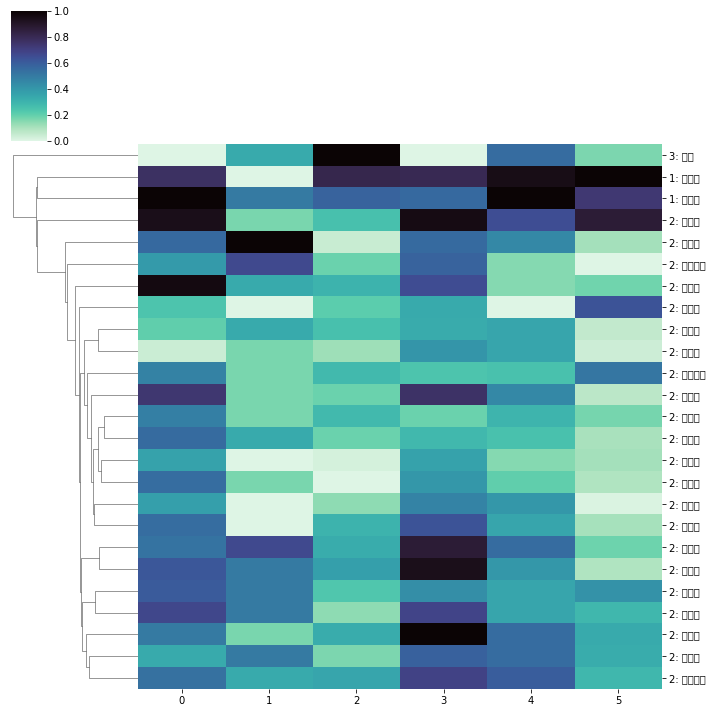

In [133]:
memb = fcluster(linkage(g_n, 'single'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='single', col_cluster=False,  cmap="mako_r")
plt.show()

In [134]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 1 :  강남구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,0.883061,0.250000,0.697674,0.680851,0.975000,0.865420
2,0.509774,0.310606,0.212474,0.561358,0.354545,0.225119
3,0.000000,0.333333,1.000000,0.000000,0.550000,0.161475


In [135]:
grouped.agg('mean').rename(columns={0:'sum_hh',1:'count_zero',2:'count_market',3:'count_bus',4:'count_station',5:'sum_waste'})

,sum_hh,count_zero,count_market,count_bus,count_station,sum_waste
cluster,,,,,,
1,0.883061,0.250000,0.697674,0.680851,0.975000,0.865420
2,0.509774,0.310606,0.212474,0.561358,0.354545,0.225119
3,0.000000,0.333333,1.000000,0.000000,0.550000,0.161475


In [137]:
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

1 :  강남구, 송파구
2 :  강동구, 강북구, 강서구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중랑구
3 :  중구


#### 1-2 complete

In [17]:
g_n = goo_norm.copy()

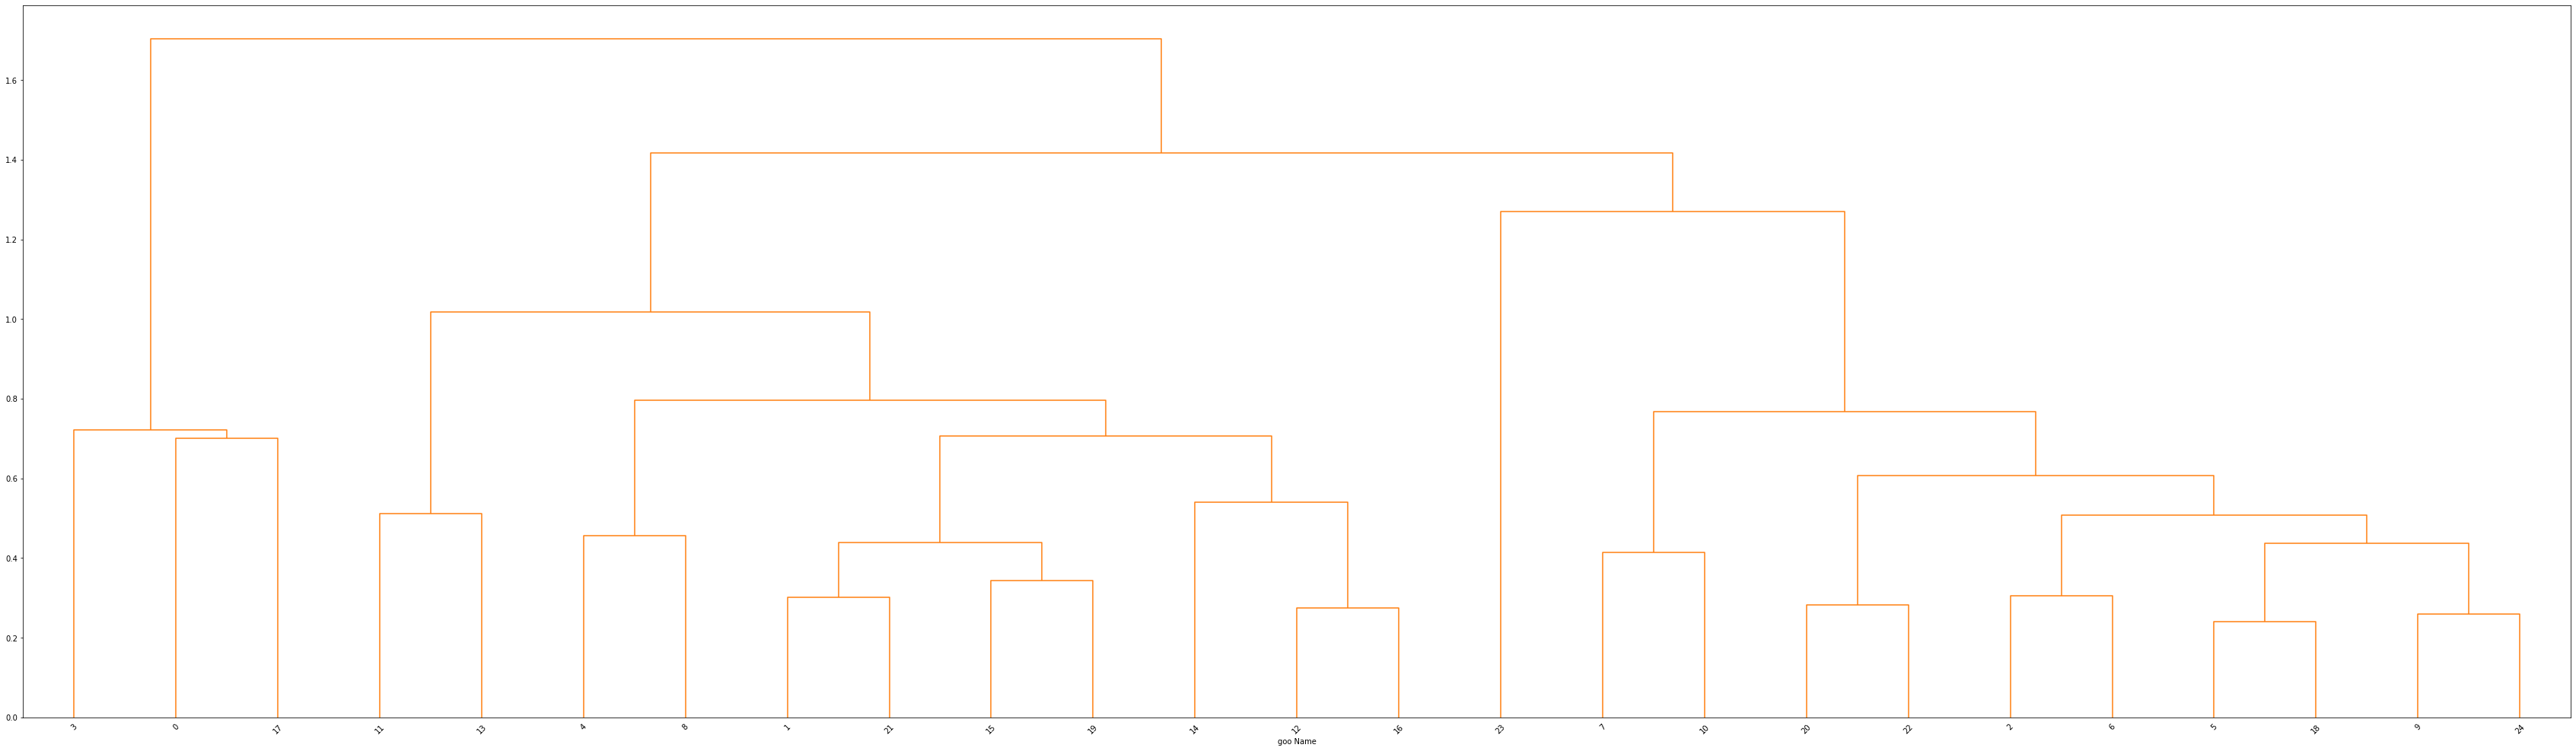

In [18]:
# 덴드로그램

Z = linkage(g_n, method='complete') # single / complete / average 
# complete 어느 정도 수준까지 같은 군집으로 볼 것인가

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

plt.title('')  # 계층적 군집화를 실행하는 덴드로그램
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강남구, 강서구, 송파구
2 :  강동구, 관악구, 노원구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 영등포구, 은평구
3 :  강북구, 광진구, 구로구, 금천구, 도봉구, 동대문구, 양천구, 용산구, 종로구, 중구, 중랑구


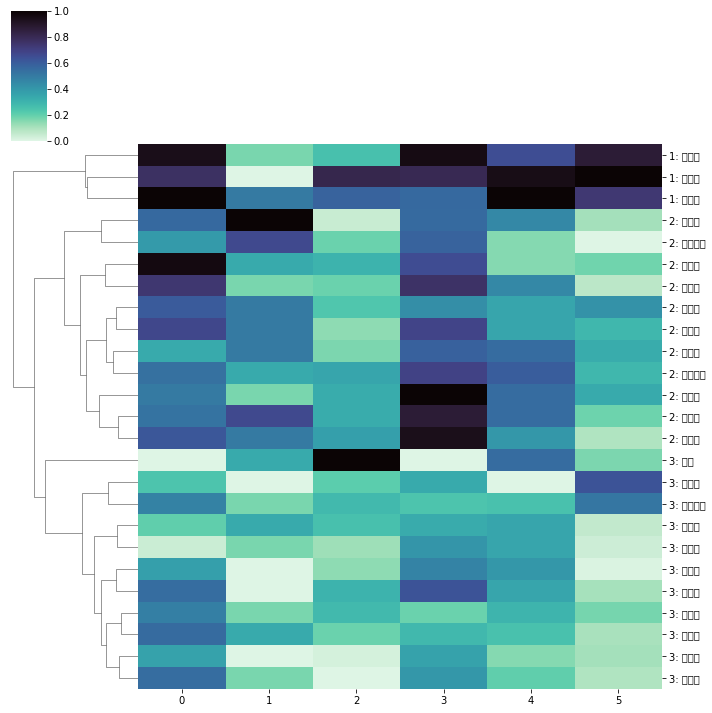

In [19]:
memb = fcluster(linkage(g_n, 'complete'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='complete', col_cluster=False,  cmap="mako_r")
plt.show()

In [20]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 1 :  강남구, 강서구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,0.902658,0.222222,0.550388,0.773838,0.866667,0.866425
2,0.586811,0.484848,0.238901,0.704277,0.413636,0.206379
3,0.347113,0.151515,0.253700,0.331184,0.286364,0.179590


#### 1-3 average 

In [21]:
g_n = goo_norm.copy()

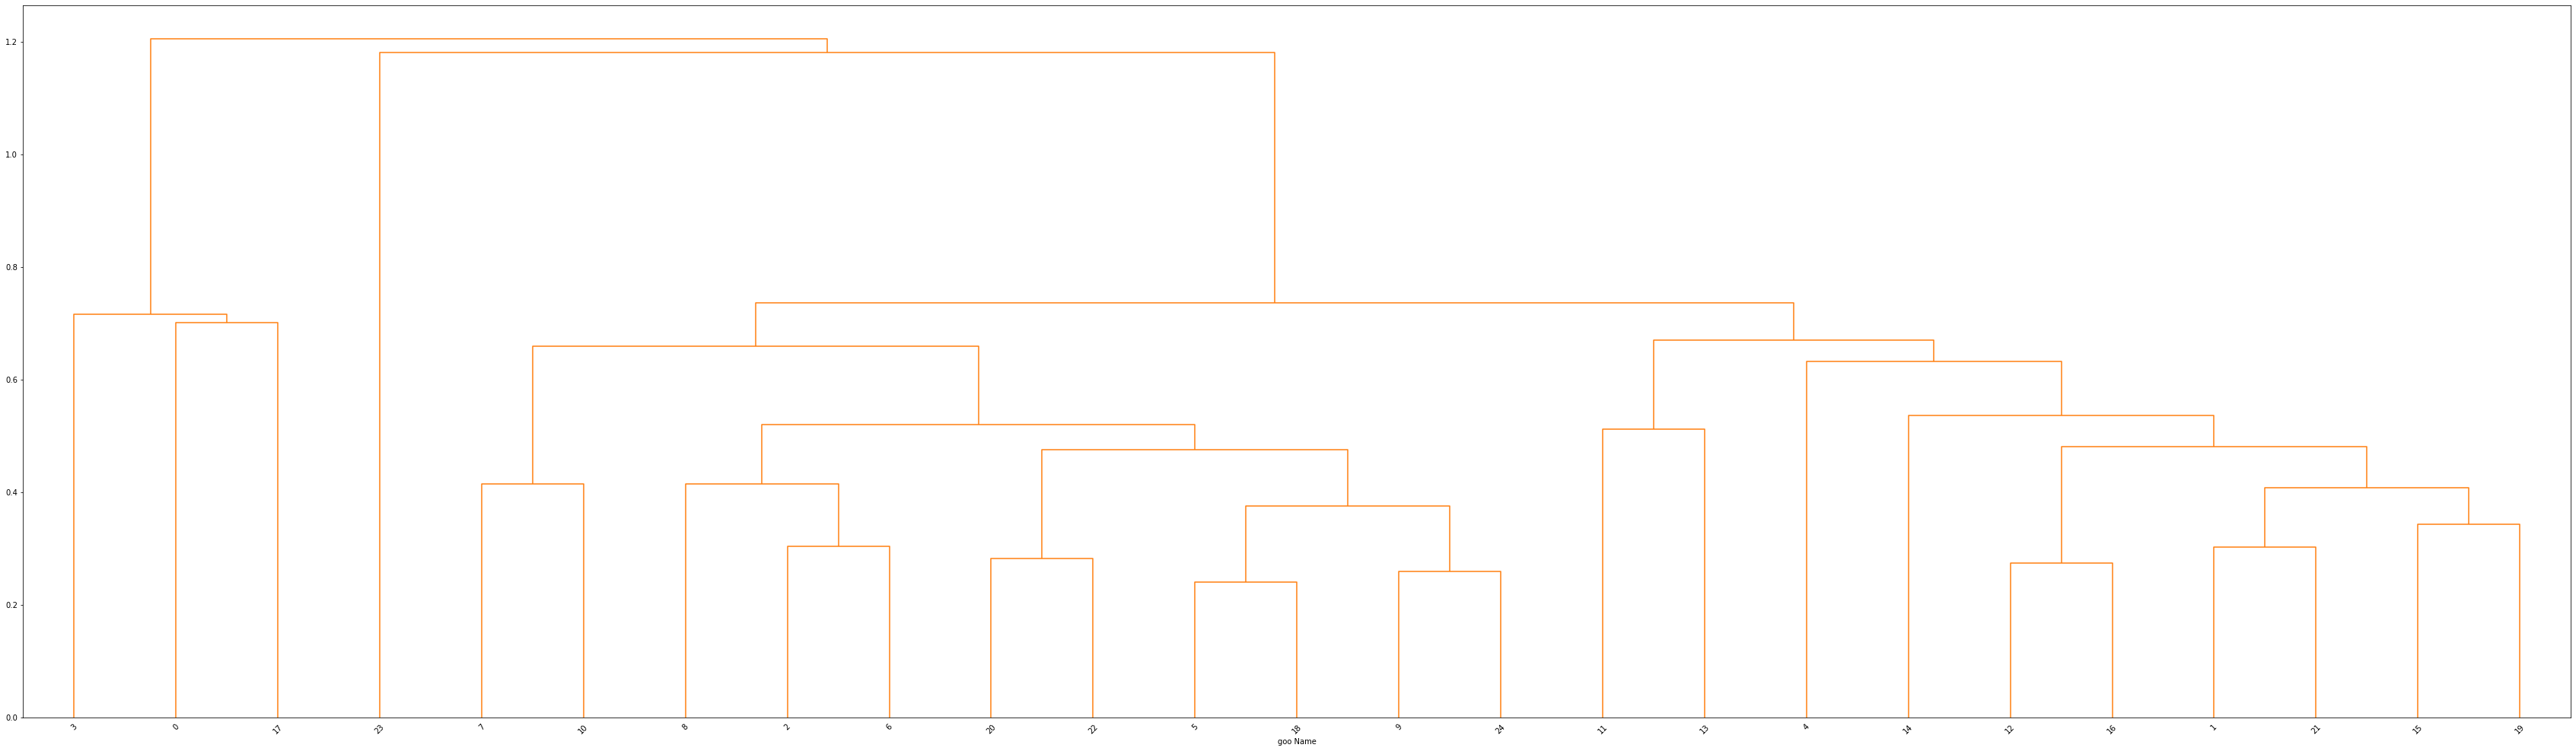

In [22]:
# 덴드로그램

Z = linkage(g_n, method='average') # single / complete / average 
# complete 어느 정도 수준까지 같은 군집으로 볼 것인가

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

plt.title('')  # 계층적 군집화를 실행하는 덴드로그램
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강남구, 강서구, 송파구
2 :  강동구, 강북구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중랑구
3 :  중구


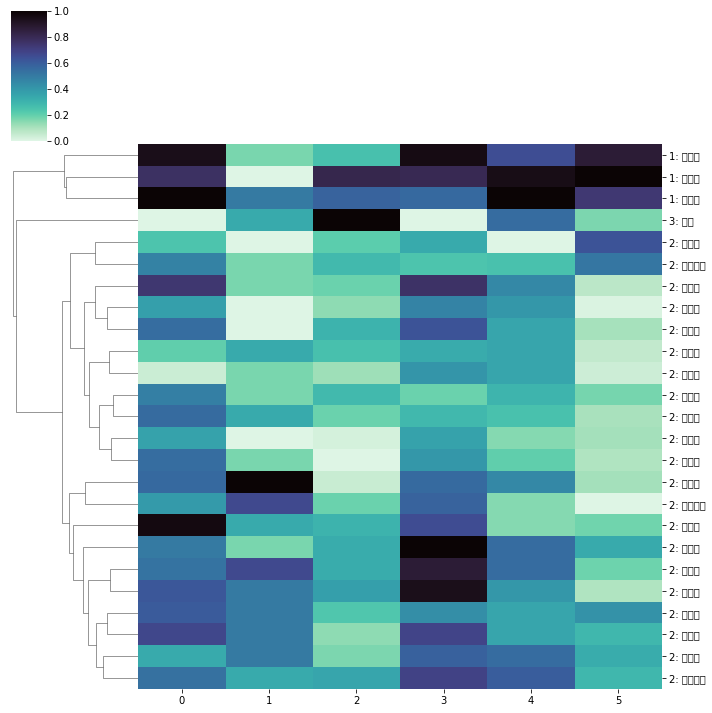

In [23]:
memb = fcluster(linkage(g_n, 'average'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='average', col_cluster=False,  cmap="mako_r")
plt.show()

In [24]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 1 :  강남구, 강서구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,0.902658,0.222222,0.550388,0.773838,0.866667,0.866425
2,0.489199,0.317460,0.210410,0.542384,0.340476,0.194485
3,0.000000,0.333333,1.000000,0.000000,0.550000,0.161475


###### 1-4 centroid

In [25]:
g_n = goo_norm.copy()

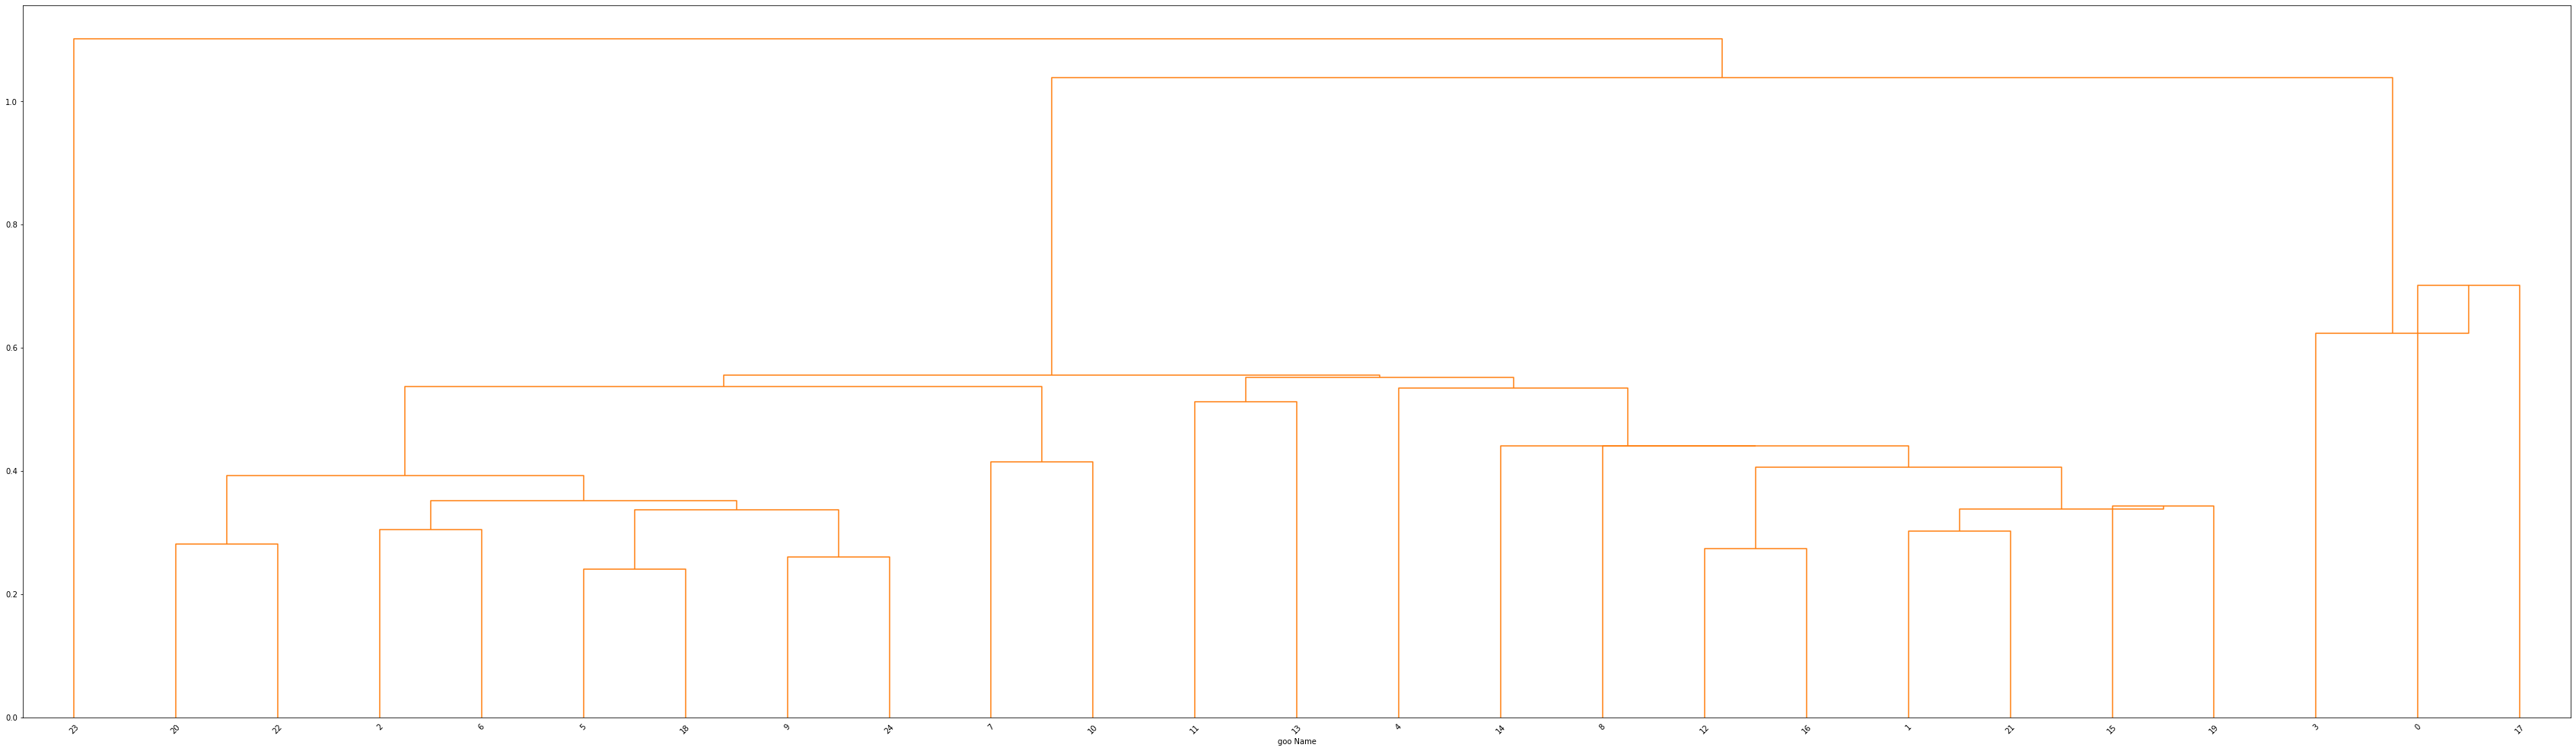

In [26]:
# 덴드로그램

Z = linkage(g_n, method='centroid') # single / complete / average 
# complete 어느 정도 수준까지 같은 군집으로 볼 것인가

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

plt.title('')  # 계층적 군집화를 실행하는 덴드로그램
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강동구, 강북구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중랑구
2 :  강남구, 강서구, 송파구
3 :  중구


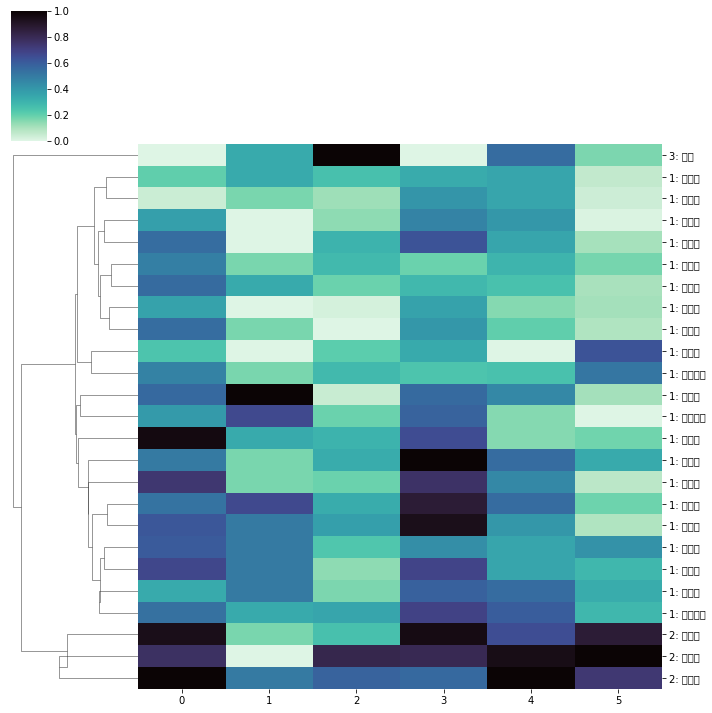

In [27]:
memb = fcluster(linkage(g_n, 'centroid'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='centroid', col_cluster=False,  cmap="mako_r")
plt.show()

In [28]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 2 :  강남구, 강서구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,0.489199,0.317460,0.210410,0.542384,0.340476,0.194485
2,0.902658,0.222222,0.550388,0.773838,0.866667,0.866425
3,0.000000,0.333333,1.000000,0.000000,0.550000,0.161475


##### 1-5 ward

In [29]:
g_n = goo_norm.copy()

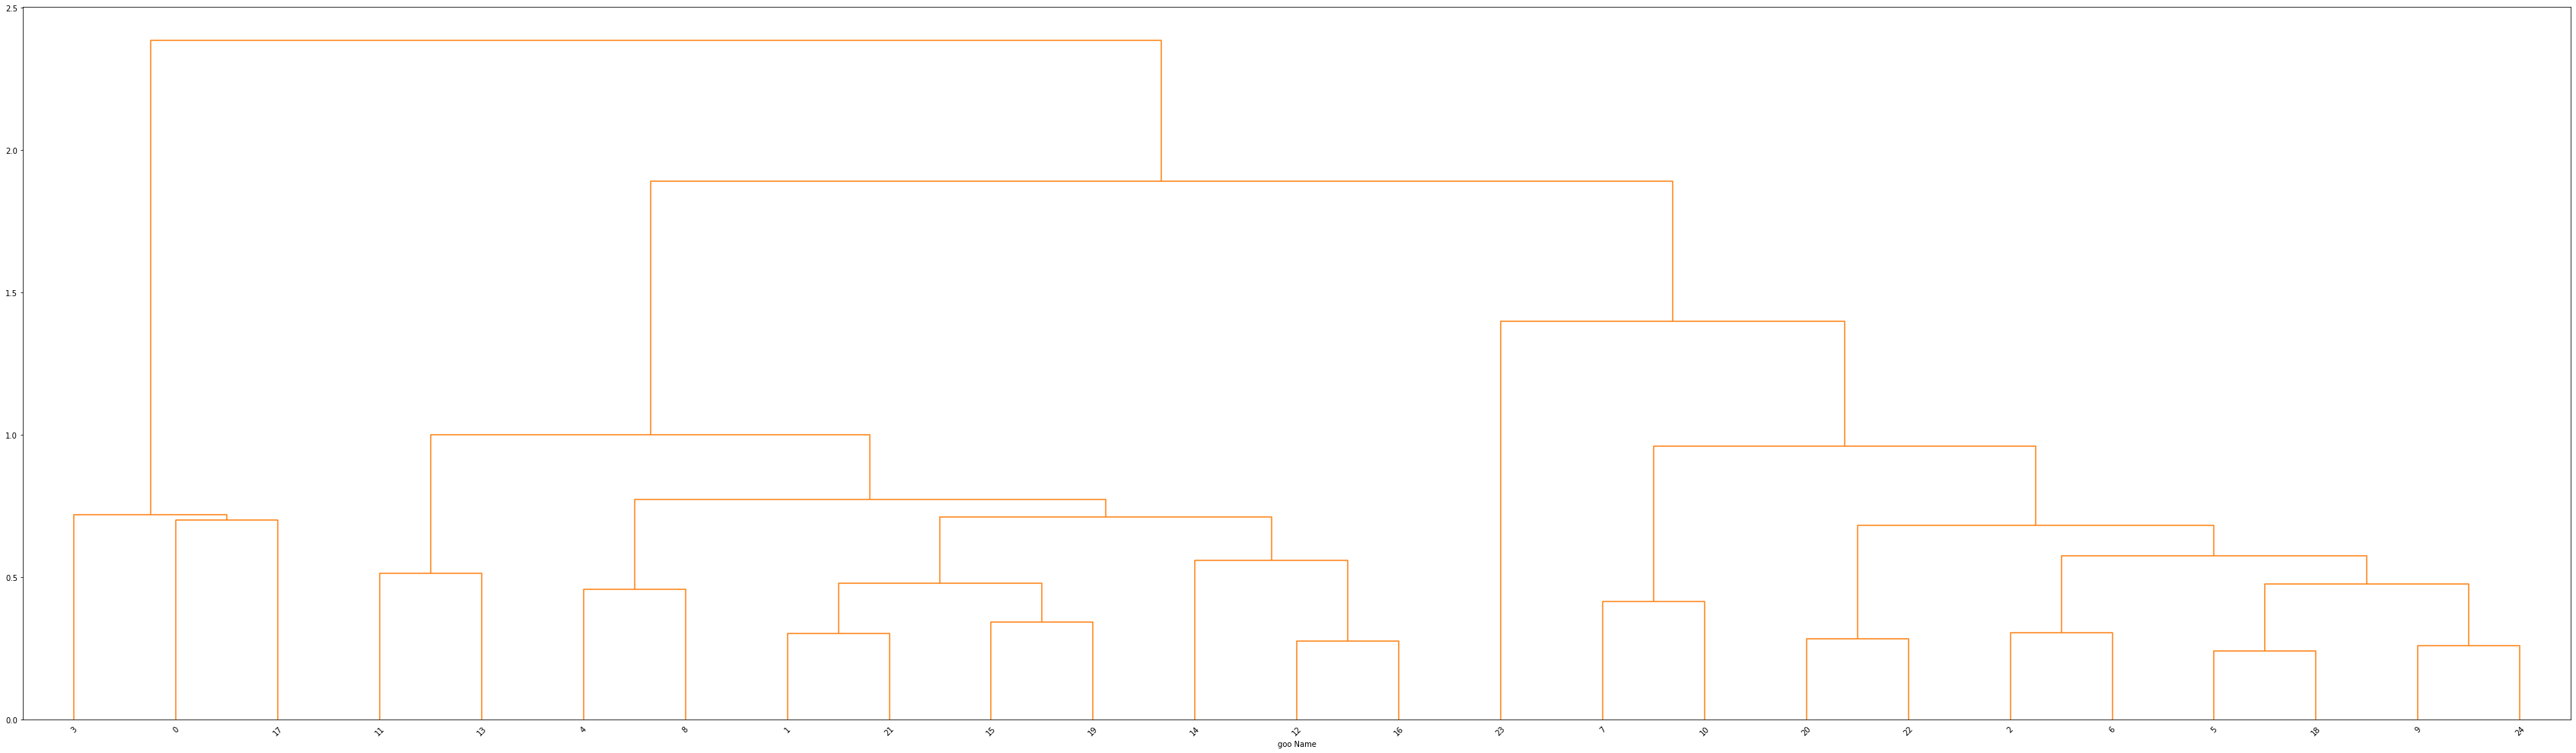

In [30]:
# 덴드로그램

Z = linkage(g_n, method='ward') 
# complete 어느 정도 수준까지 같은 군집으로 볼 것인가

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

plt.title('')  # 계층적 군집화를 실행하는 덴드로그램
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강남구, 강서구, 송파구
2 :  강동구, 관악구, 노원구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 영등포구, 은평구
3 :  강북구, 광진구, 구로구, 금천구, 도봉구, 동대문구, 양천구, 용산구, 종로구, 중구, 중랑구


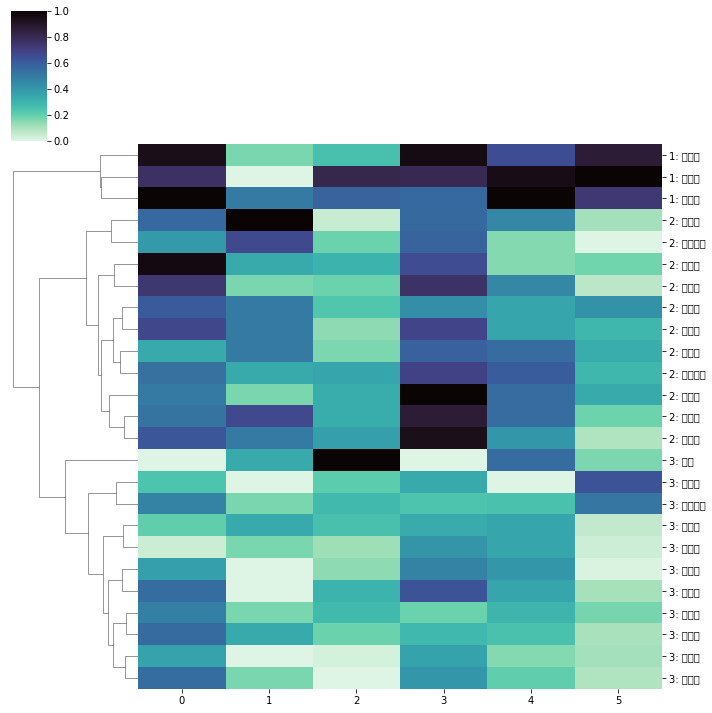

In [31]:
memb = fcluster(linkage(g_n, 'ward'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='ward', col_cluster=False,  cmap="mako_r")
plt.show()

In [32]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 2 :  강남구, 강서구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,0.902658,0.222222,0.550388,0.773838,0.866667,0.866425
2,0.586811,0.484848,0.238901,0.704277,0.413636,0.206379
3,0.347113,0.151515,0.253700,0.331184,0.286364,0.179590


## 2) standard

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(goo_df)
goo_norm = pd.DataFrame(data, index = list(goo_df.index))

2-1 single
<br>
2-2 complete
<br>
2-3 average
<br>
2-4 centroid
<br>
2-5 ward
#### 2-1 single

In [34]:
g_n = goo_norm.copy()

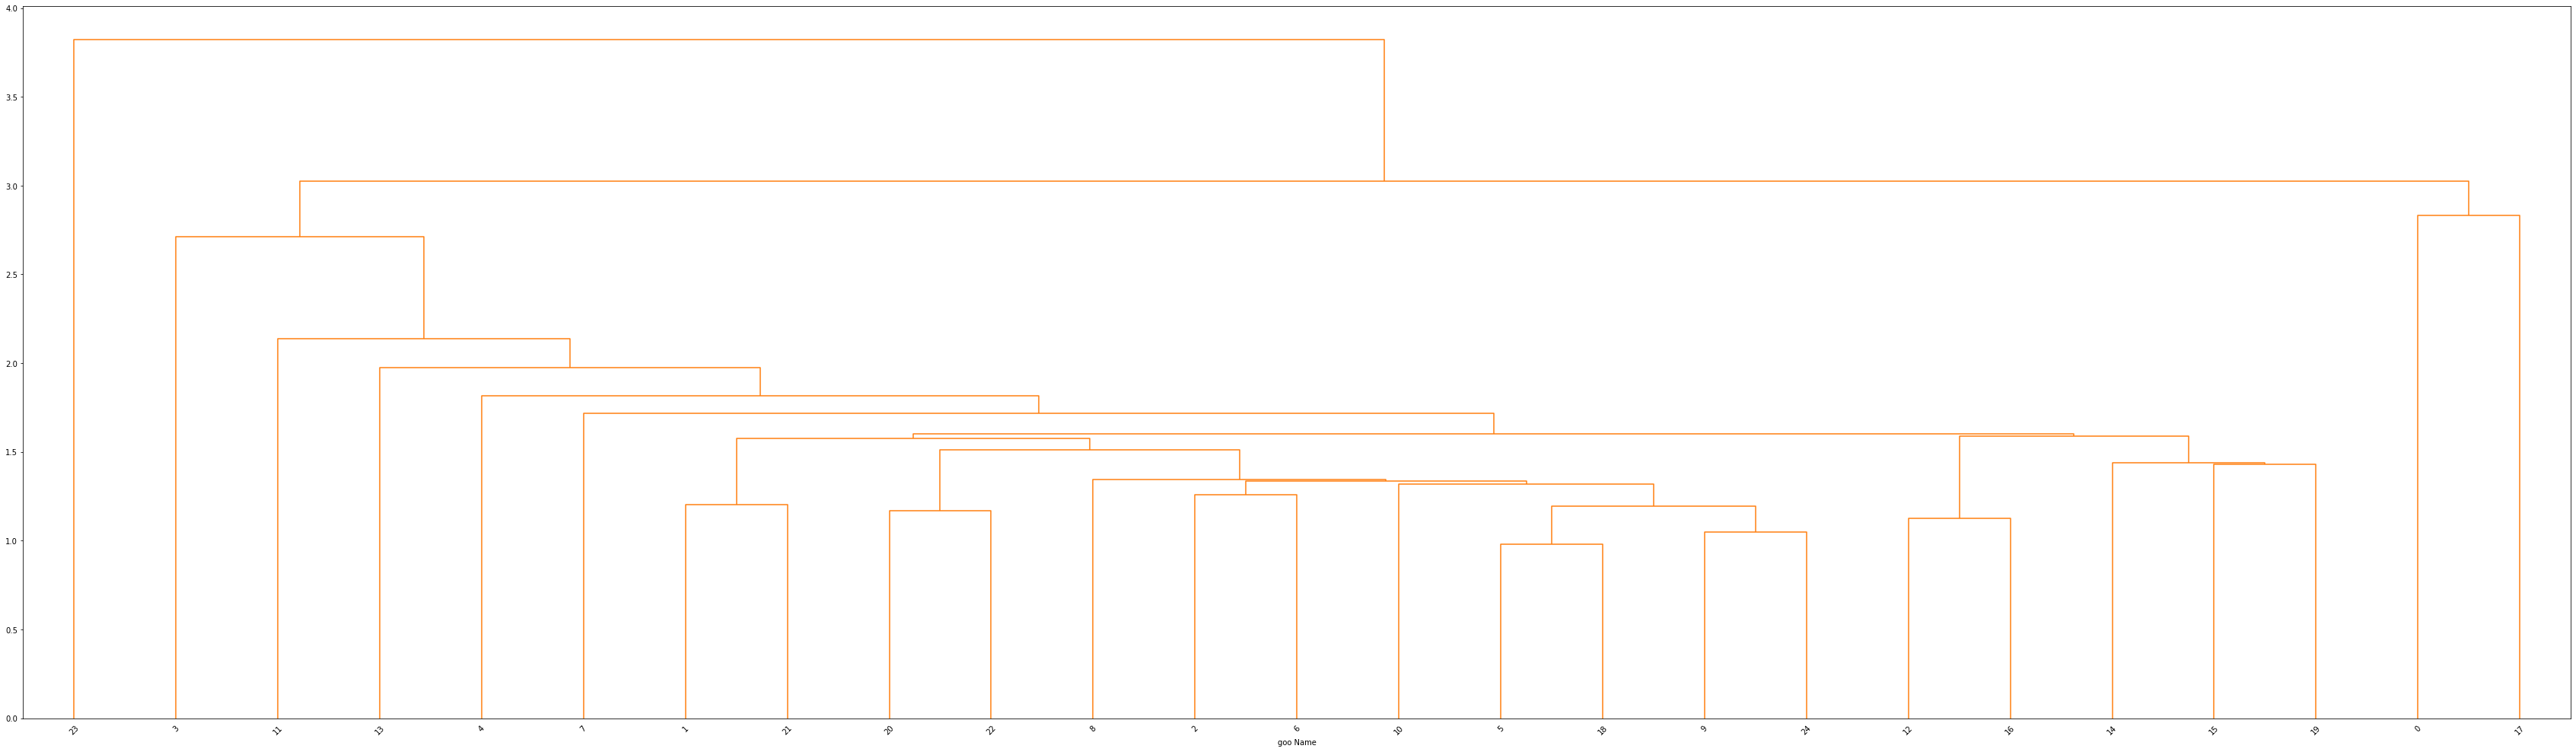

In [35]:
# 덴드로그램

Z = linkage(g_n, method='single') # single / complete / average 
# complete 어느 정도 수준까지 같은 군집으로 볼 것인가

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

plt.title('')  # 계층적 군집화를 실행하는 덴드로그램
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강동구, 강북구, 강서구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중랑구
2 :  강남구, 송파구
3 :  중구


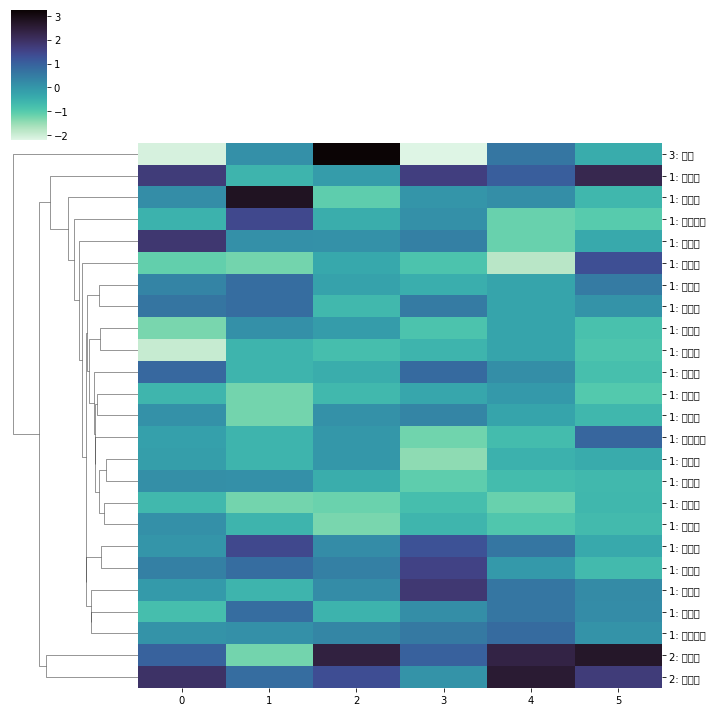

In [36]:
memb = fcluster(linkage(g_n, 'single'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='single', col_cluster=False,  cmap="mako_r")
plt.show()

In [37]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 2 :  강남구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,-0.038144,0.015884,-0.317497,0.051253,-0.250857,-0.180477
2,1.465076,-0.228481,1.873288,0.526201,2.458164,2.193471
3,-2.090992,0.107521,3.238353,-2.179974,0.602534,-0.416439


#### 2-2 complete

In [38]:
g_n = goo_norm.copy()

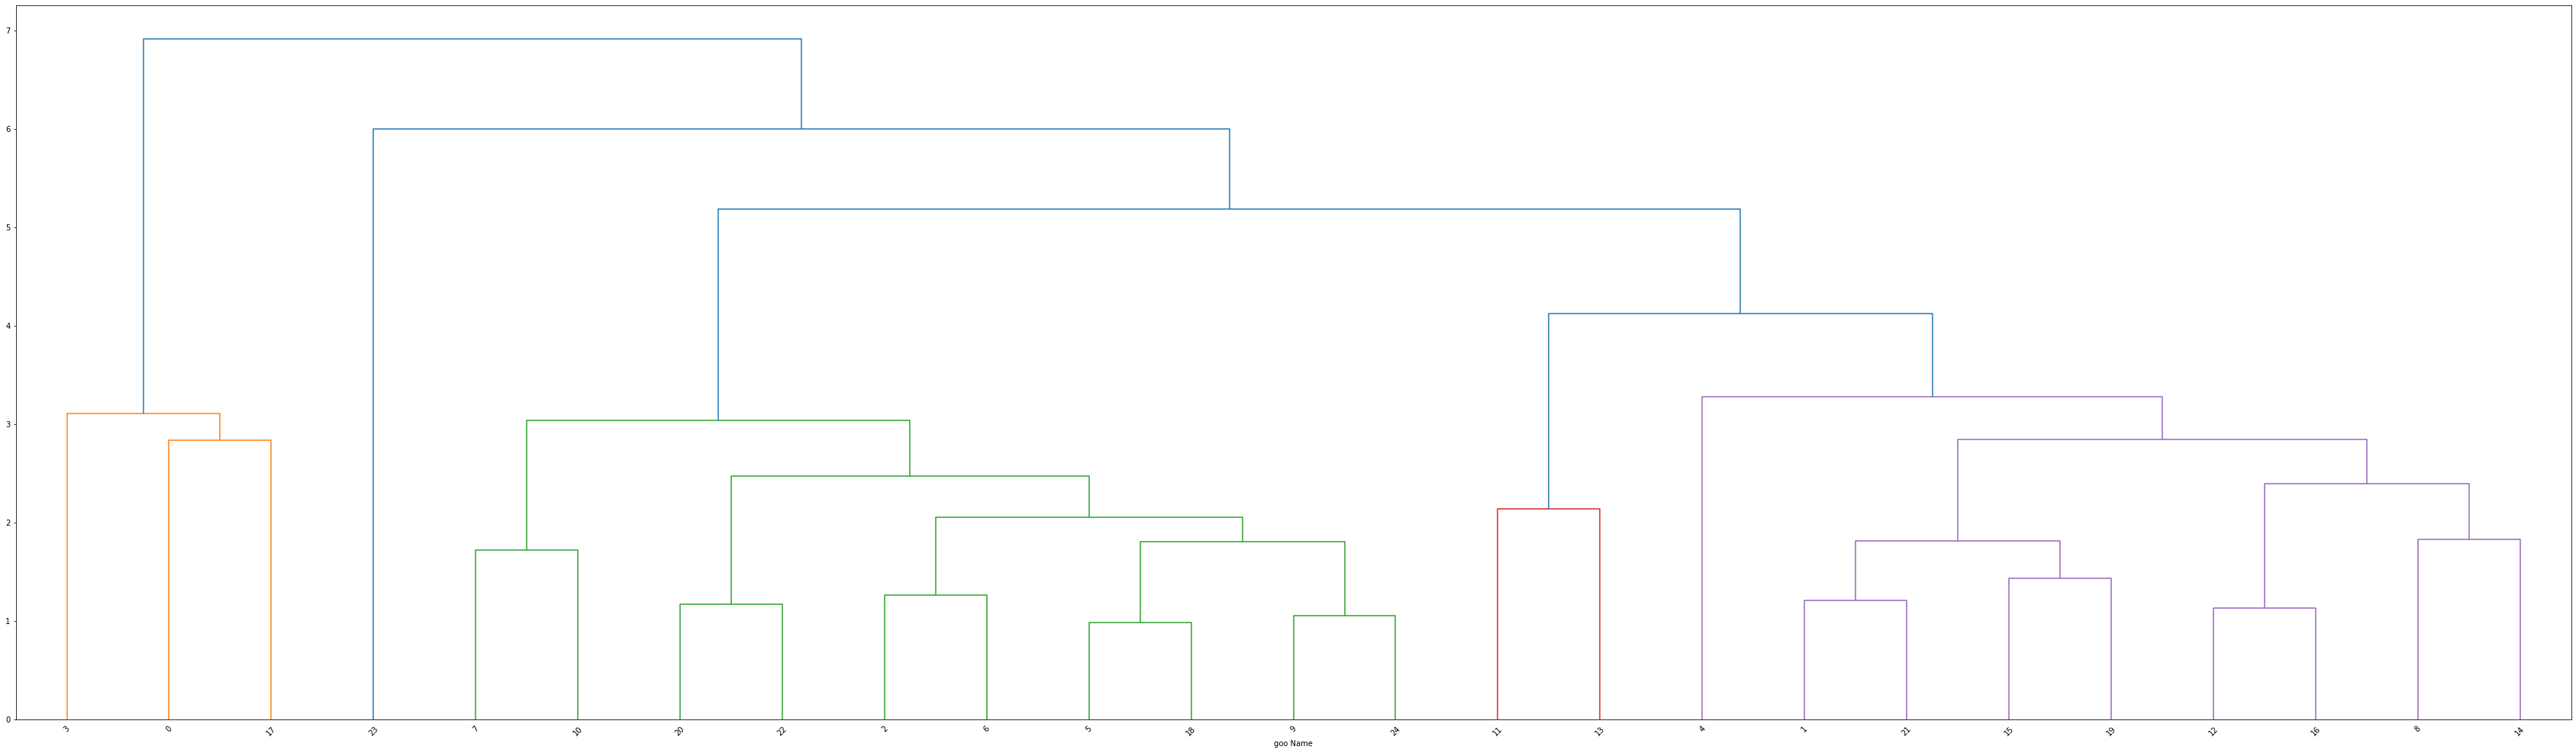

In [39]:
# 덴드로그램

Z = linkage(g_n, method='complete') 
# complete 어느 정도 수준까지 같은 군집으로 볼 것인가

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

plt.title('')  # 계층적 군집화를 실행하는 덴드로그램
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강남구, 강서구, 송파구
2 :  강동구, 강북구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중랑구
3 :  중구


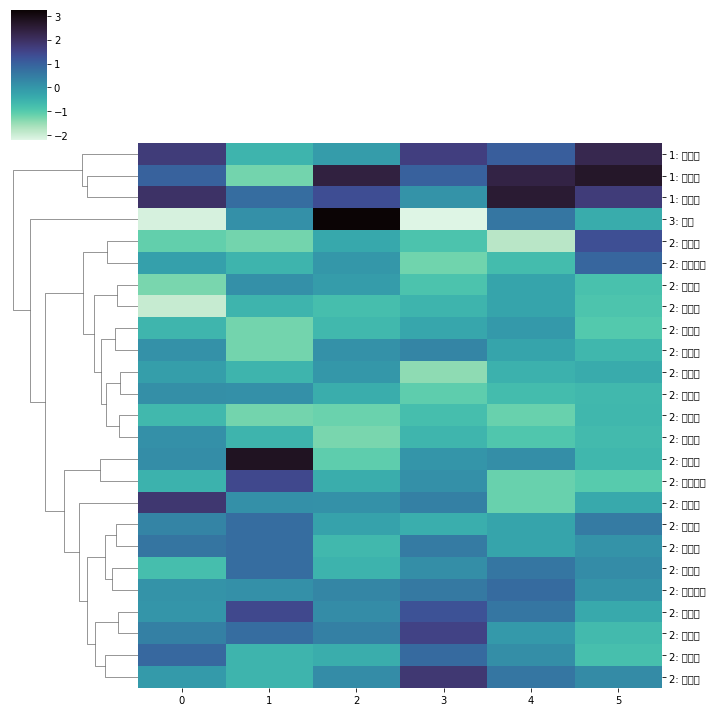

In [40]:
memb = fcluster(linkage(g_n, 'complete'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='complete', col_cluster=False,  cmap="mako_r")
plt.show()

In [41]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 2 :  강남구, 강서구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,1.543991,-0.340482,1.208257,0.895794,1.985160,2.197198
2,-0.120999,0.043520,-0.326815,-0.024162,-0.312286,-0.294055
3,-2.090992,0.107521,3.238353,-2.179974,0.602534,-0.416439


#### 2-3 average 

In [42]:
g_n = goo_norm.copy()

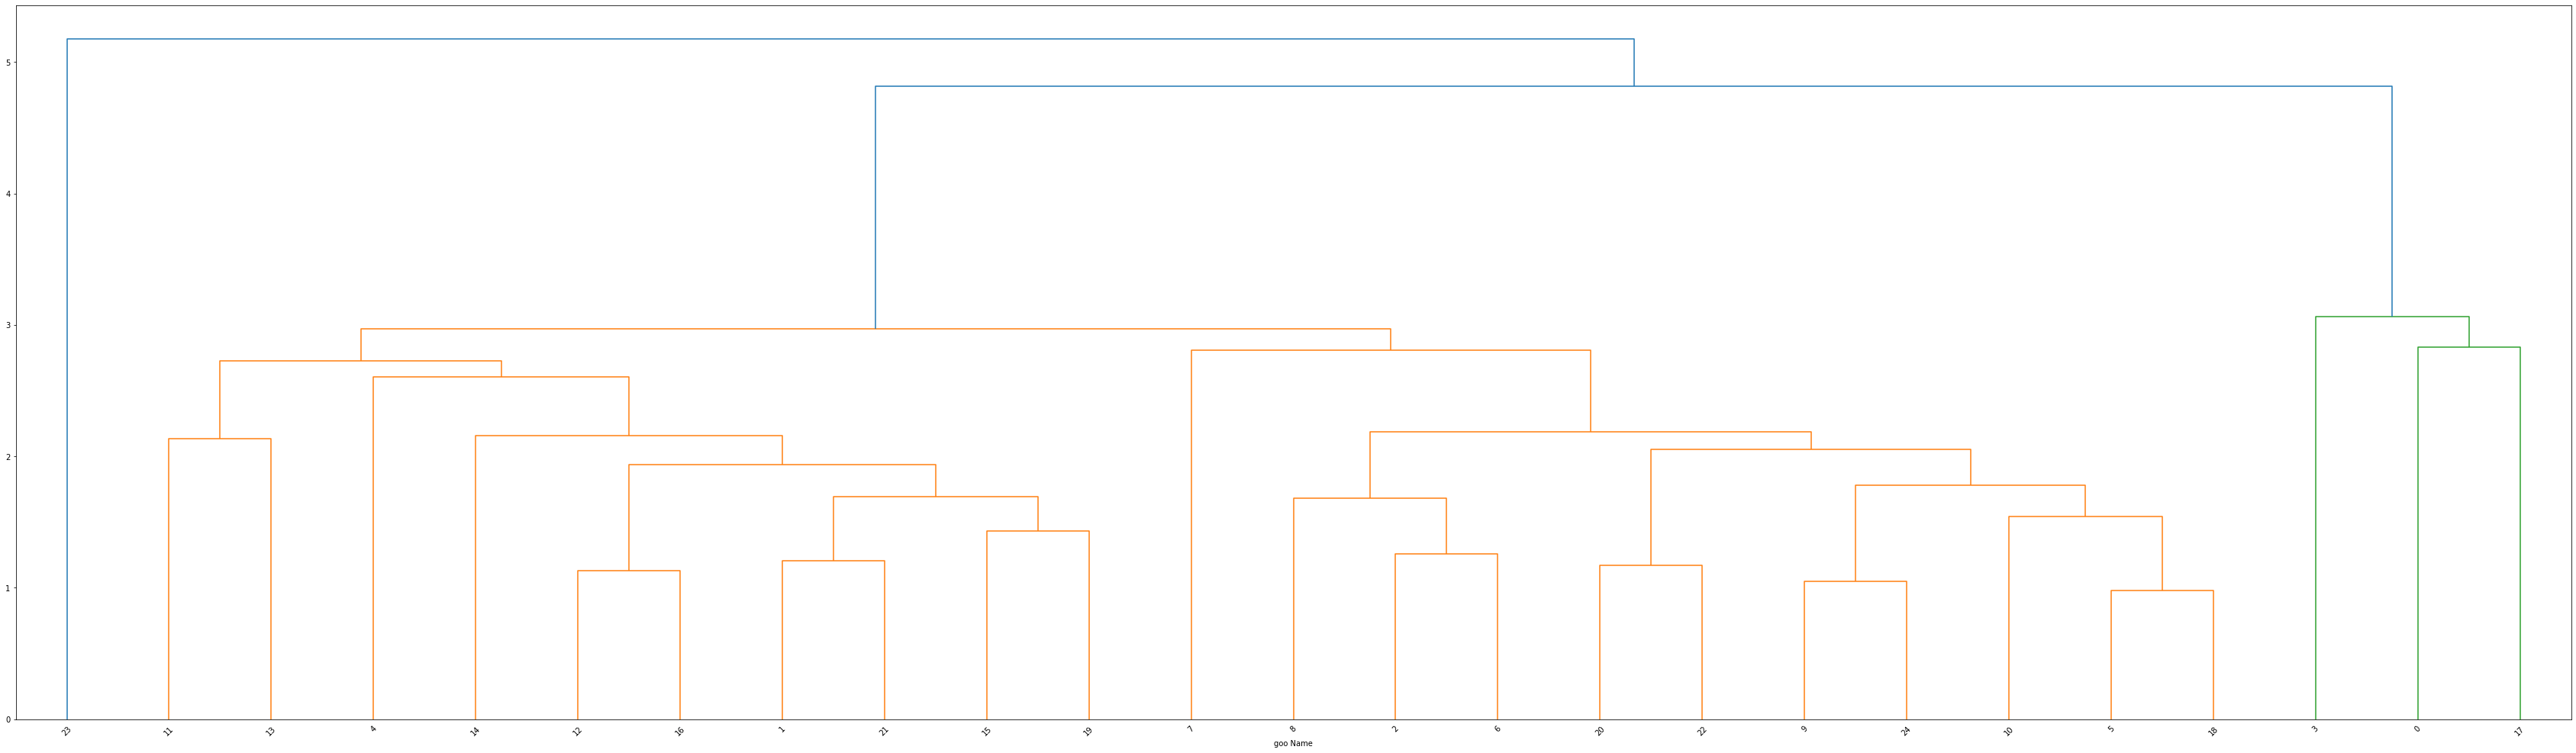

In [43]:
# 덴드로그램

Z = linkage(g_n, method='average') 

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

# 계층적 군집화를 실행하는 덴드로그램
plt.title('')  
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강동구, 강북구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중랑구
2 :  강남구, 강서구, 송파구
3 :  중구


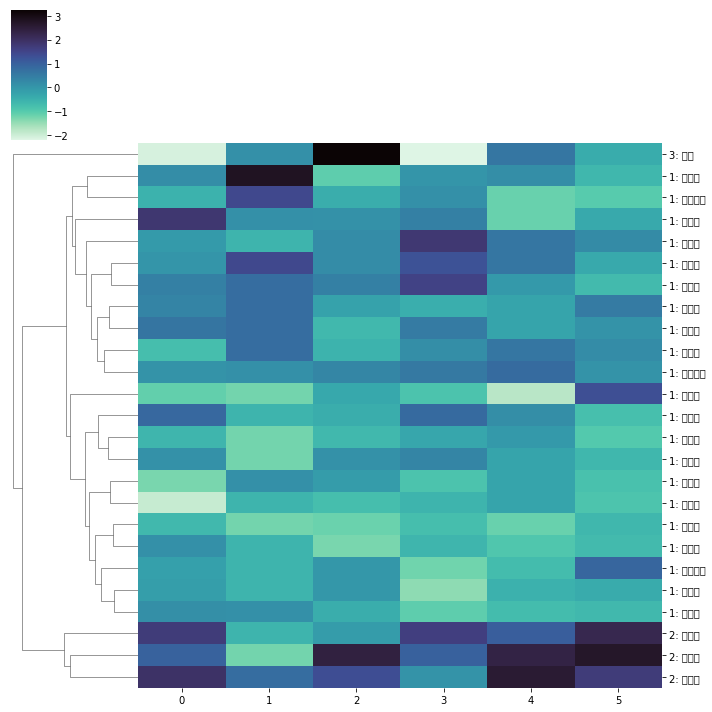

In [44]:
memb = fcluster(linkage(g_n, 'average'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='average', col_cluster=False,  cmap="mako_r")
plt.show()

In [45]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 2 :  강남구, 강서구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,-0.120999,0.043520,-0.326815,-0.024162,-0.312286,-0.294055
2,1.543991,-0.340482,1.208257,0.895794,1.985160,2.197198
3,-2.090992,0.107521,3.238353,-2.179974,0.602534,-0.416439


##### 2-4 centroid

In [46]:
g_n = goo_norm.copy()

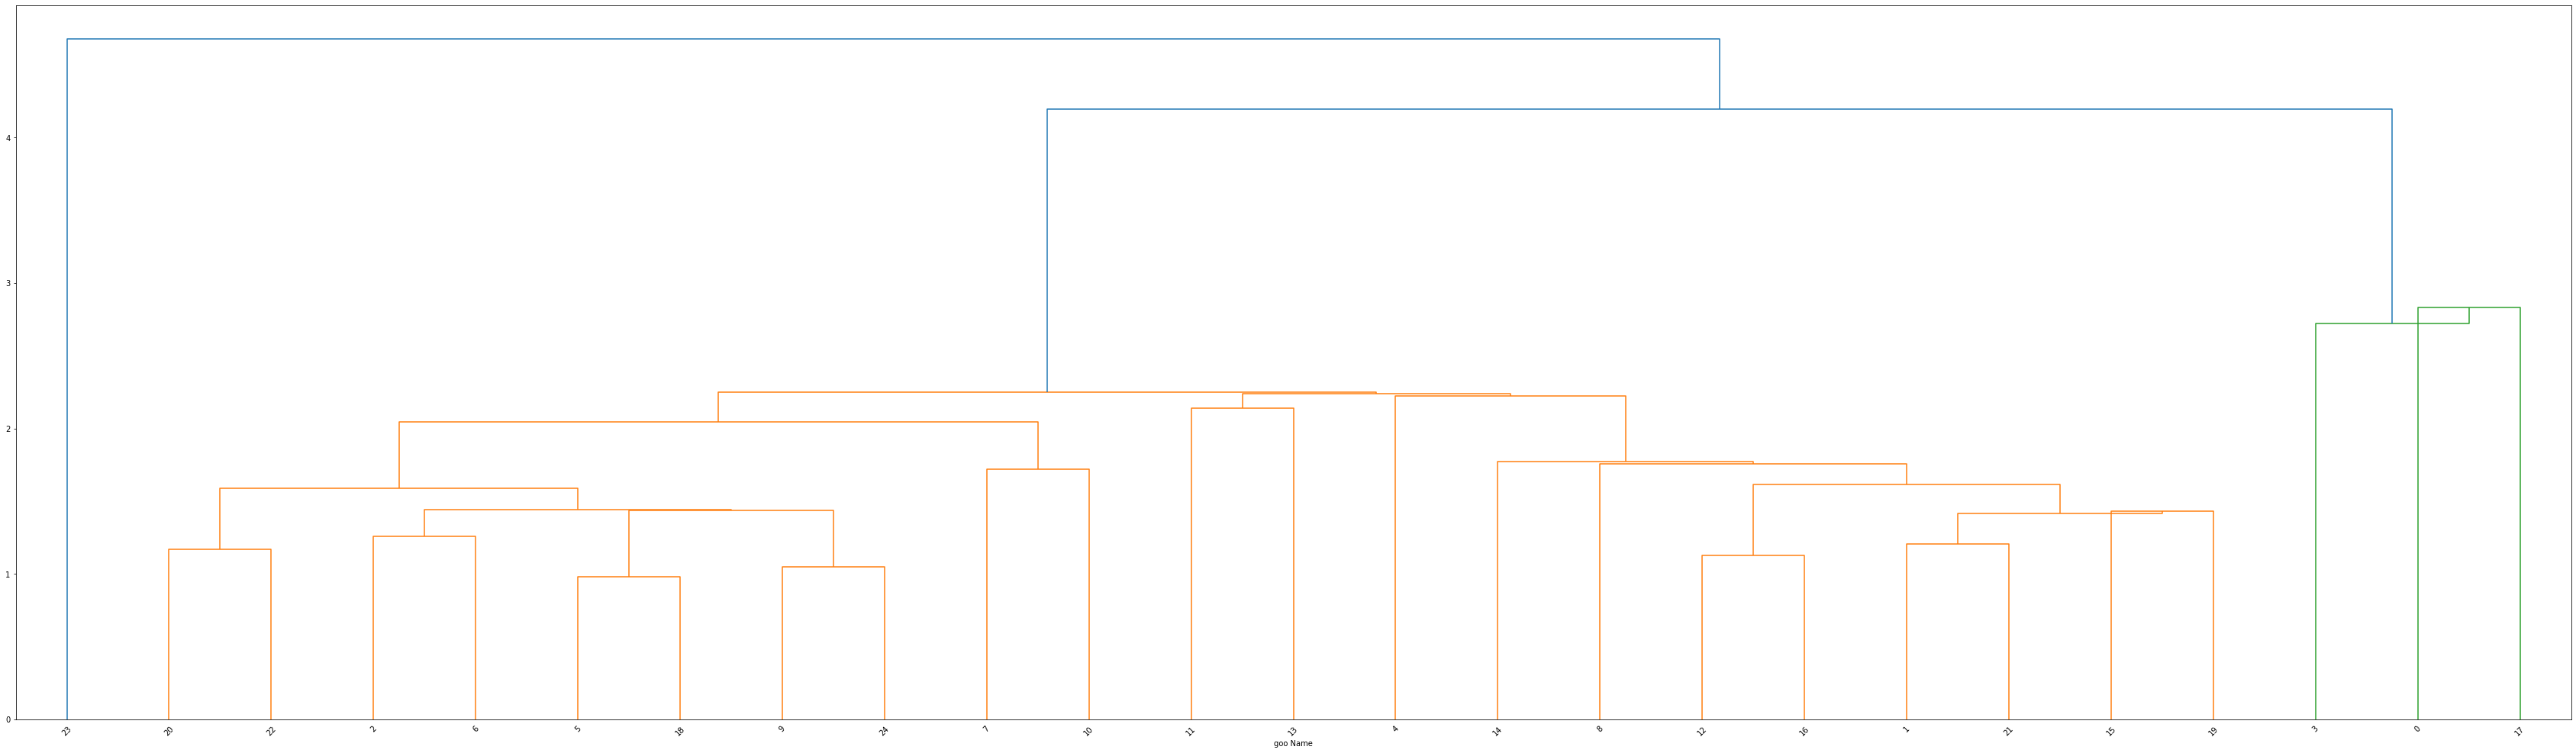

In [47]:
# 덴드로그램

Z = linkage(g_n, method='centroid') 

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

plt.title('')  # 계층적 군집화를 실행하는 덴드로그램
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강동구, 강북구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중랑구
2 :  강남구, 강서구, 송파구
3 :  중구


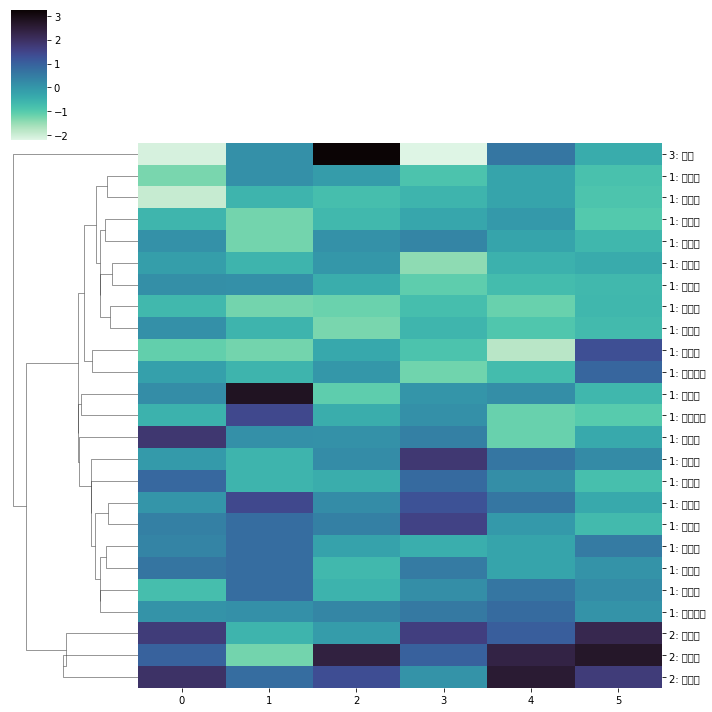

In [48]:
memb = fcluster(linkage(g_n, 'centroid'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='centroid', col_cluster=False,  cmap="mako_r")
plt.show()

In [49]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 2 :  강남구, 강서구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,-0.120999,0.043520,-0.326815,-0.024162,-0.312286,-0.294055
2,1.543991,-0.340482,1.208257,0.895794,1.985160,2.197198
3,-2.090992,0.107521,3.238353,-2.179974,0.602534,-0.416439


##### 2-5 ward

In [50]:
g_n = goo_norm.copy()

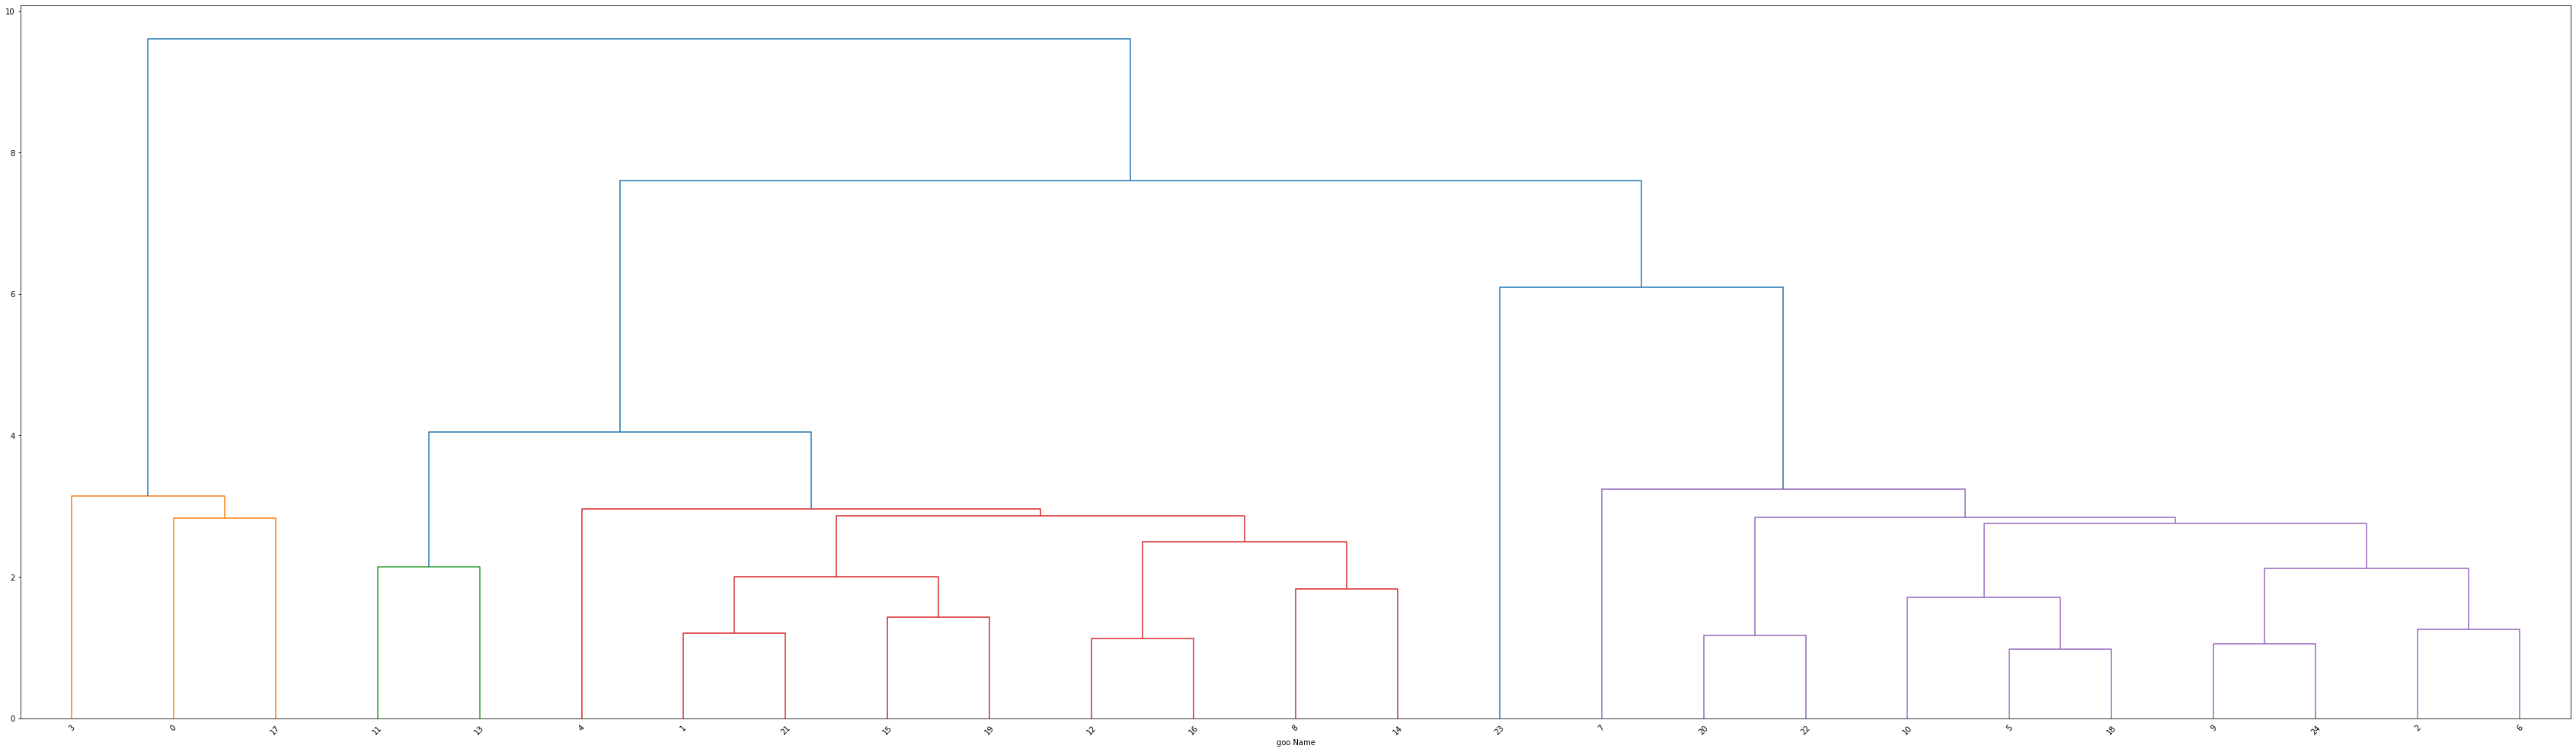

In [51]:
# 덴드로그램

Z = linkage(g_n, method='ward') 

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

plt.title('')  # 계층적 군집화를 실행하는 덴드로그램
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강남구, 강서구, 송파구
2 :  강동구, 관악구, 노원구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 영등포구, 은평구
3 :  강북구, 광진구, 구로구, 금천구, 도봉구, 동대문구, 양천구, 용산구, 종로구, 중구, 중랑구


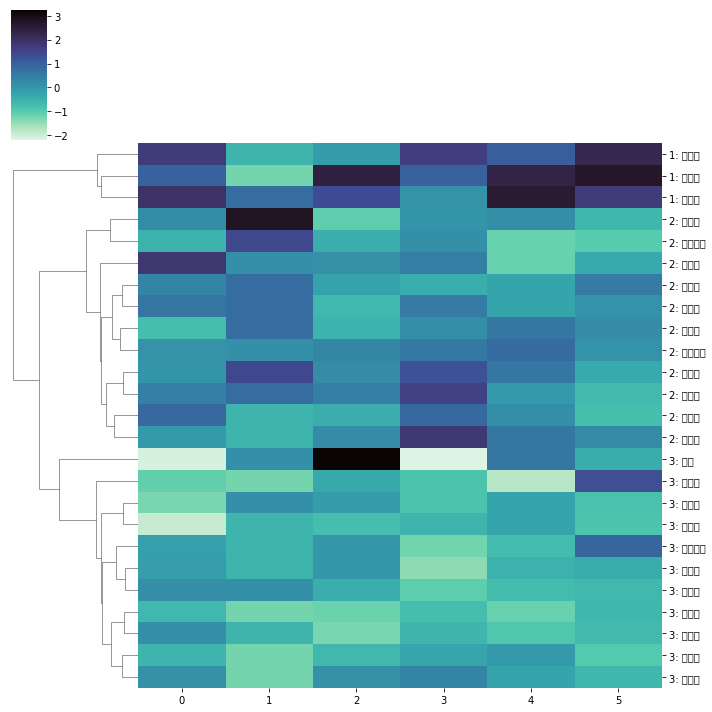

In [52]:
memb = fcluster(linkage(g_n, 'ward'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='ward', col_cluster=False,  cmap="mako_r")
plt.show()

In [53]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 2 :  강남구, 강서구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,1.543991,-0.340482,1.208257,0.895794,1.985160,2.197198
2,0.272085,0.718434,-0.198173,0.619311,0.007145,-0.249958
3,-0.693174,-0.625575,-0.131352,-0.863618,-0.548552,-0.349278


# 

## 3) Robust

In [54]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
data = scaler.fit_transform(goo_df)
goo_norm = pd.DataFrame(data, index = list(goo_df.index))

3-1 single
<br>
3-2 complete
<br>
3-3 average
<br>
3-4 centroid
<br>
3-5 ward
#### 3-1 single

In [55]:
g_n = goo_norm.copy()

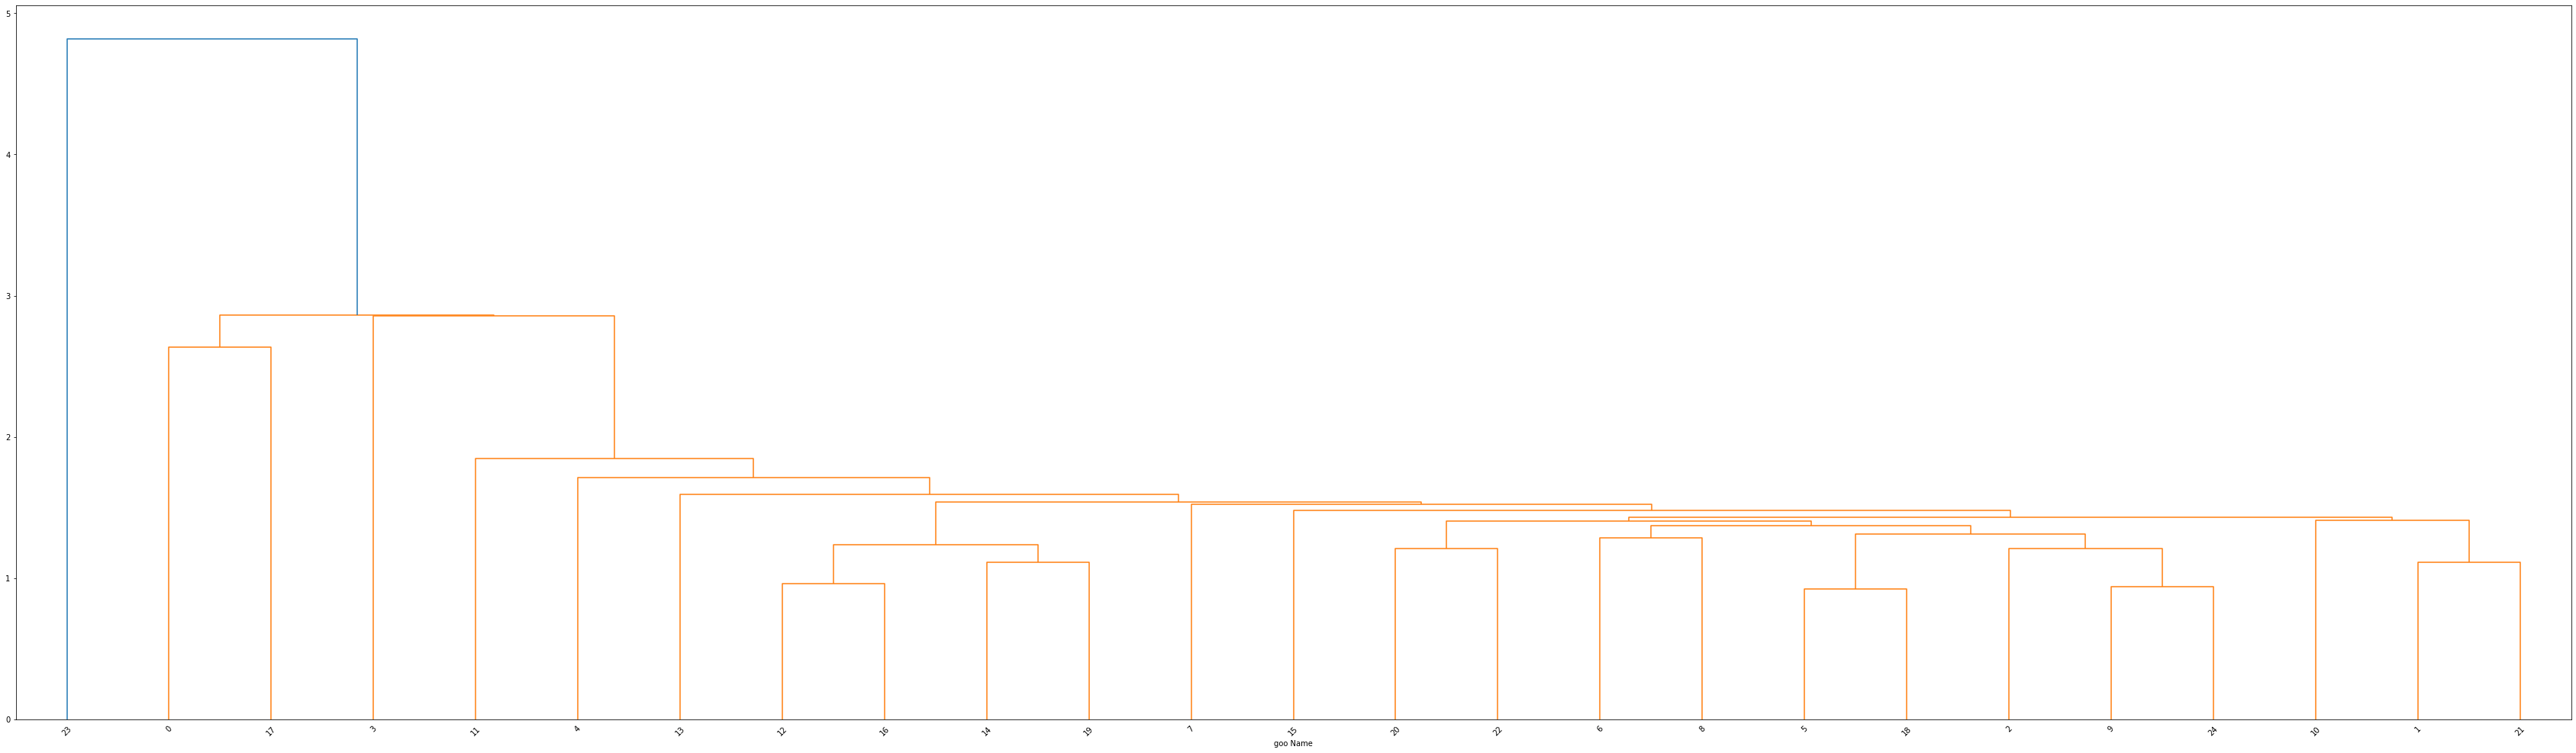

In [56]:
# 덴드로그램

Z = linkage(g_n, method='single') # single / complete / average 
# complete 어느 정도 수준까지 같은 군집으로 볼 것인가

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

plt.title('')  # 계층적 군집화를 실행하는 덴드로그램
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강남구, 송파구
2 :  강동구, 강북구, 강서구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중랑구
3 :  중구


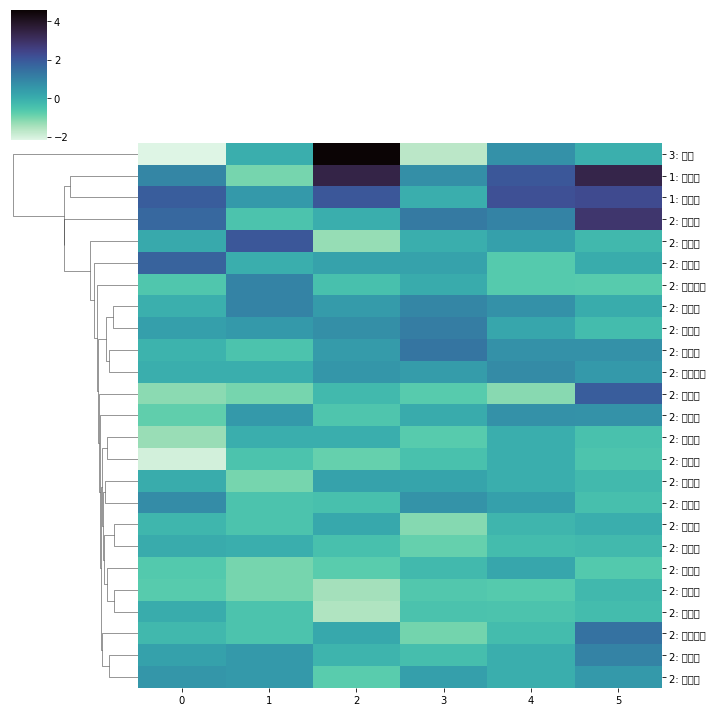

In [57]:
memb = fcluster(linkage(g_n, 'single'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='single', col_cluster=False,  cmap="mako_r")
plt.show()

In [58]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 1 :  강남구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,1.402236,-0.250000,2.714286,0.366906,2.083333,2.840628
2,-0.100294,-0.068182,-0.266234,0.003270,0.015152,0.232609
3,-2.152201,0.000000,4.571429,-1.705036,0.666667,-0.026619


###### 3-2 complete

In [59]:
g_n = goo_norm.copy()

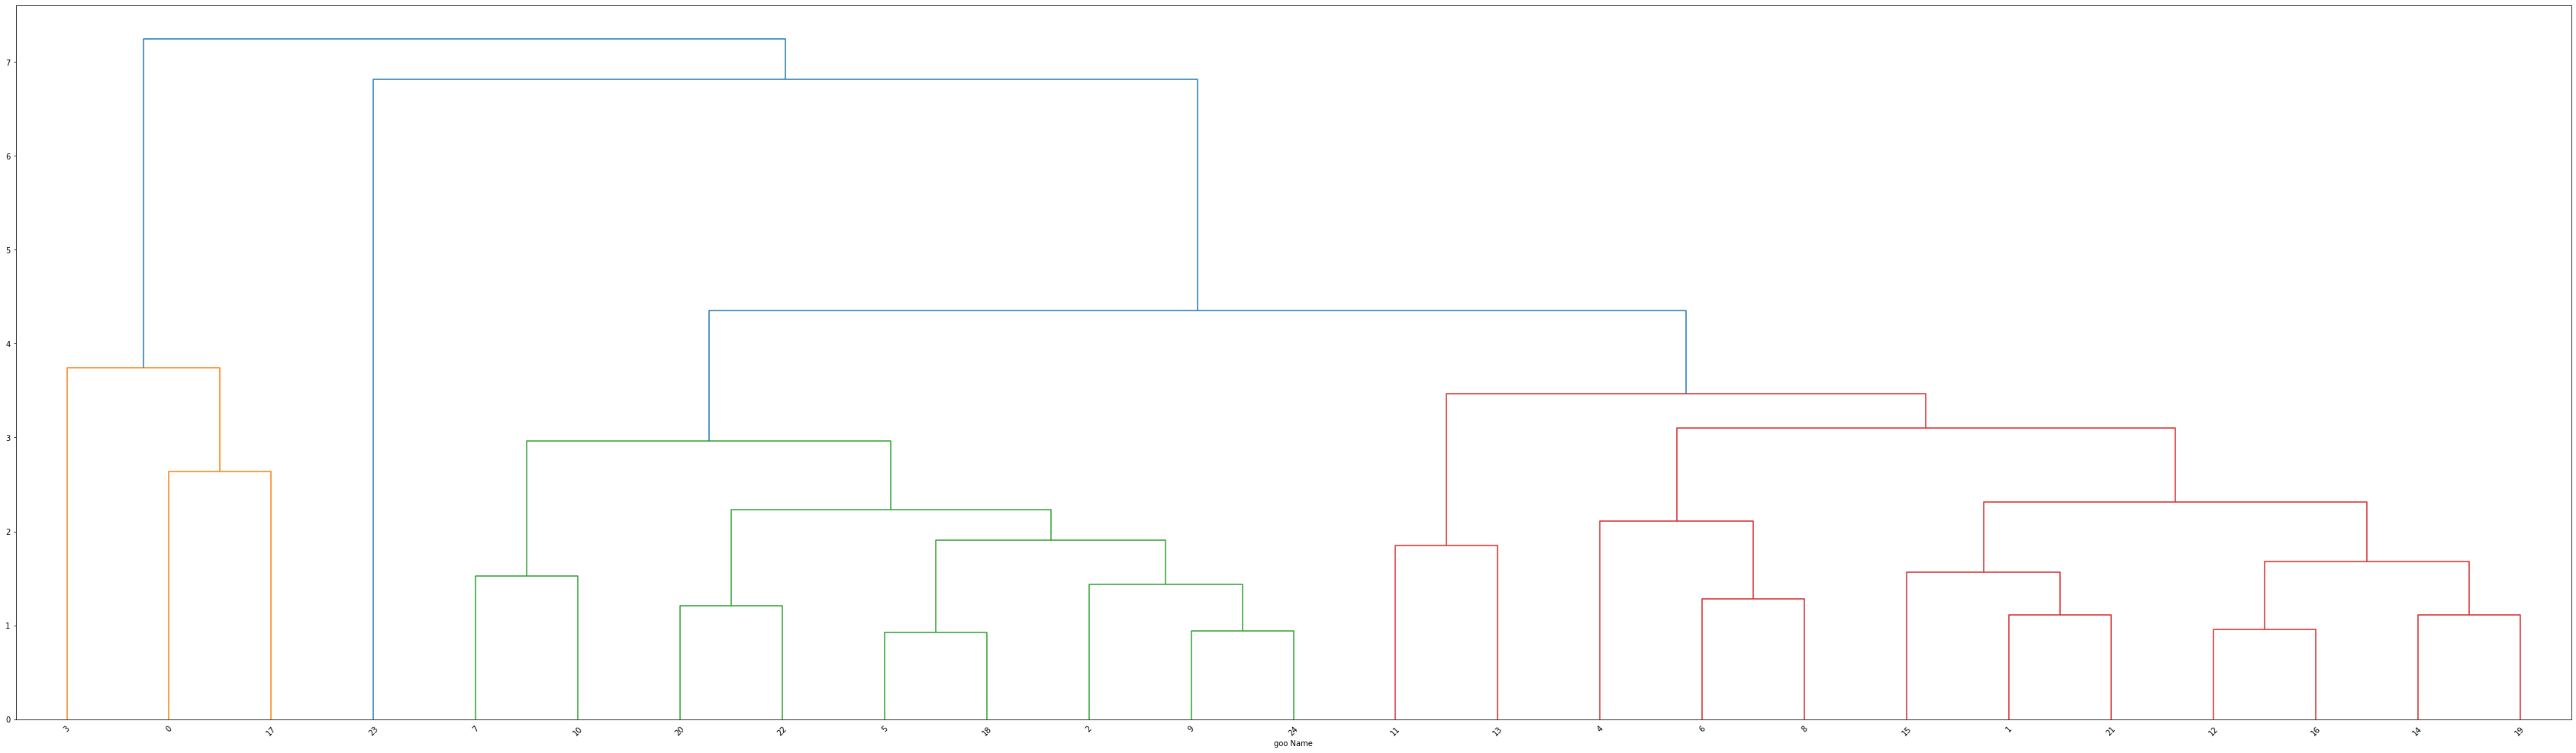

In [60]:
# 덴드로그램

Z = linkage(g_n, method='complete') # single / complete / average 
# complete 어느 정도 수준까지 같은 군집으로 볼 것인가

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

plt.title('')  # 계층적 군집화를 실행하는 덴드로그램
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강남구, 강서구, 송파구
2 :  강동구, 강북구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중랑구
3 :  중구


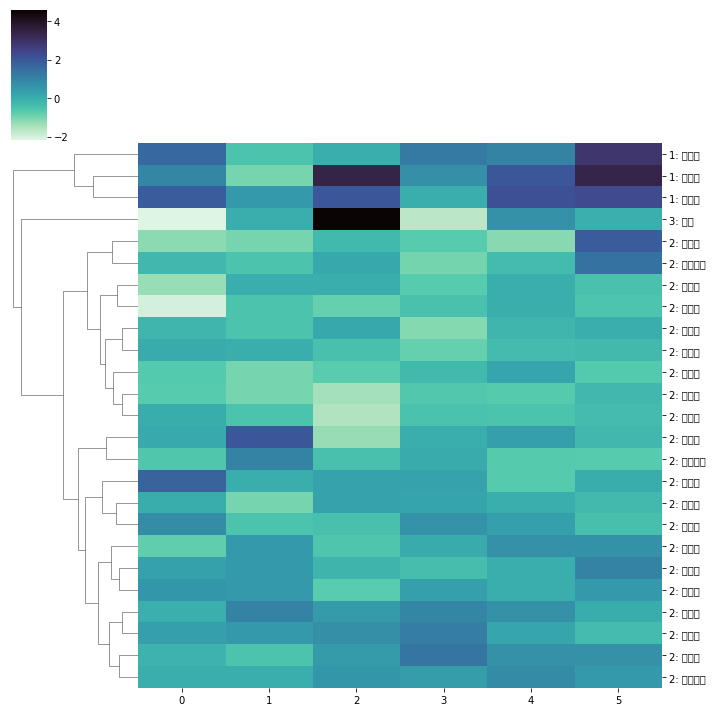

In [61]:
memb = fcluster(linkage(g_n, 'complete'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='complete', col_cluster=False,  cmap="mako_r")
plt.show()

In [62]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 1 :  강남구, 강서구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,1.481115,-0.333333,1.809524,0.649880,1.722222,2.844723
2,-0.183112,-0.047619,-0.278912,-0.054471,-0.031746,0.107833
3,-2.152201,0.000000,4.571429,-1.705036,0.666667,-0.026619


###### 3-3 average

In [63]:
g_n = goo_norm.copy()

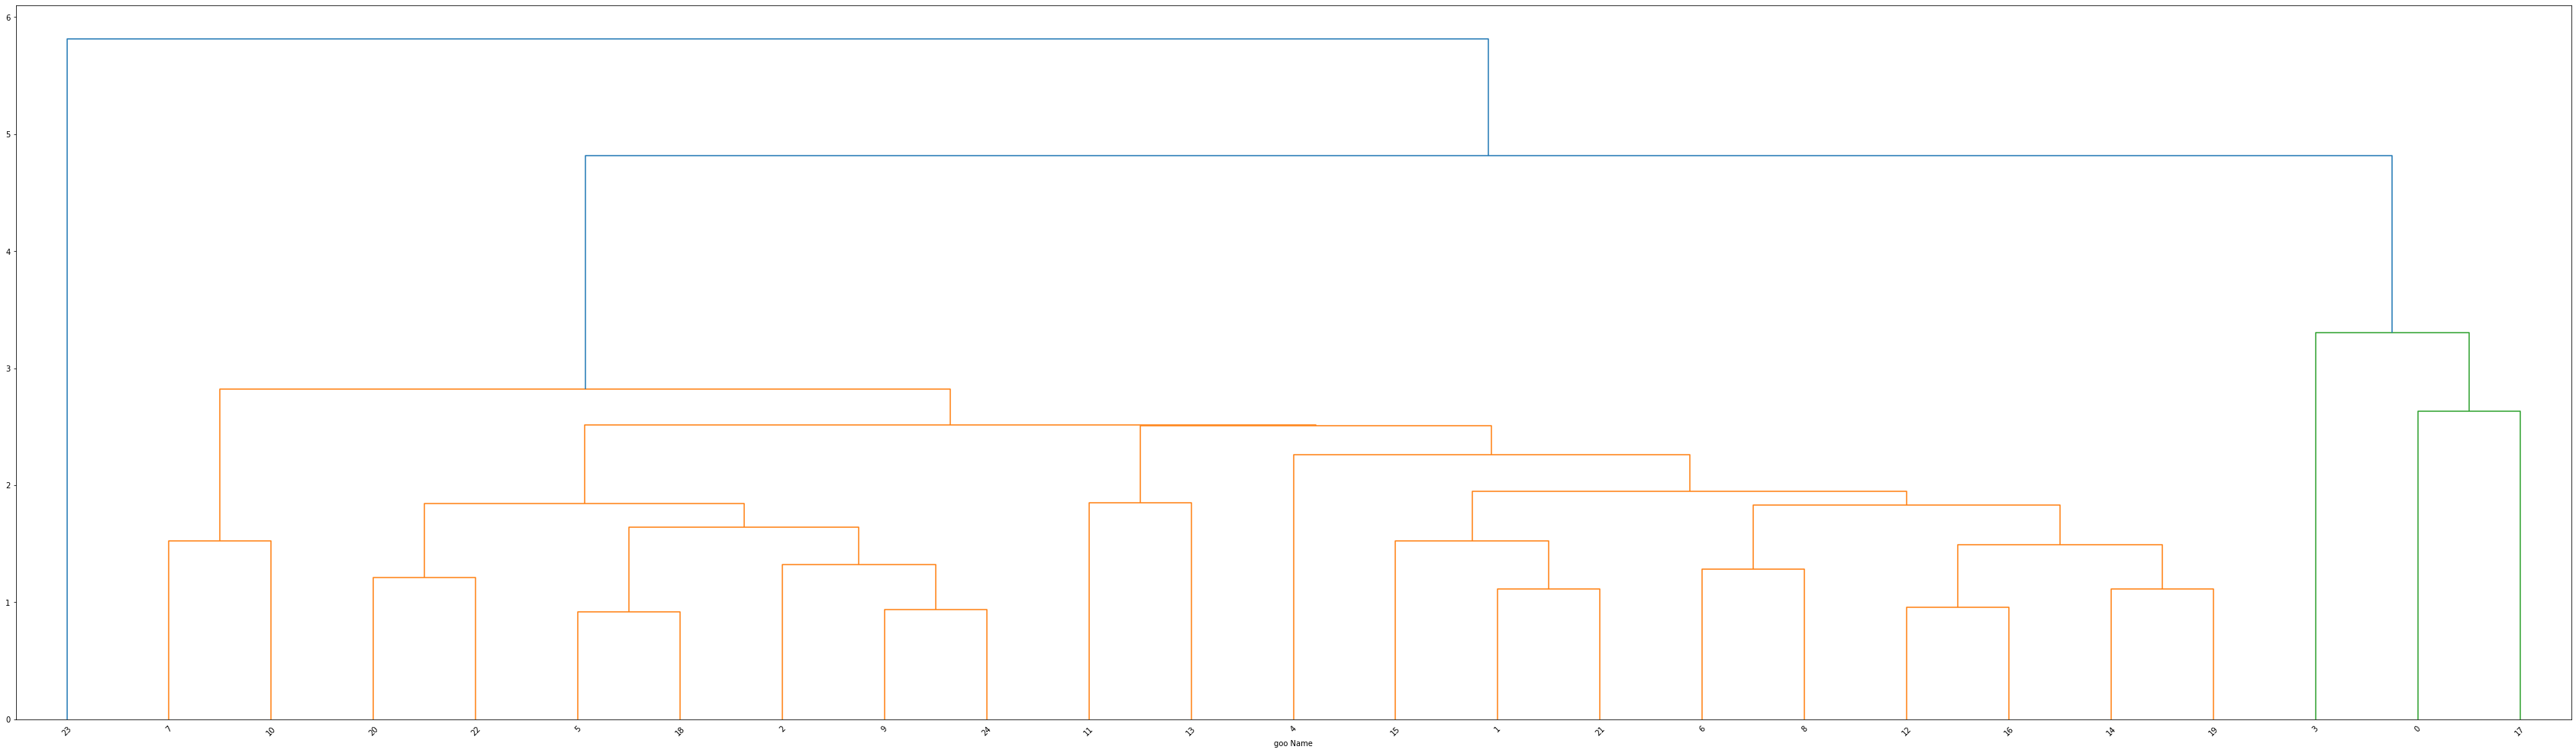

In [64]:
# 덴드로그램

Z = linkage(g_n, method='average') # single / complete / average 
# complete 어느 정도 수준까지 같은 군집으로 볼 것인가

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

plt.title('')  # 계층적 군집화를 실행하는 덴드로그램
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강동구, 강북구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중랑구
2 :  강남구, 강서구, 송파구
3 :  중구


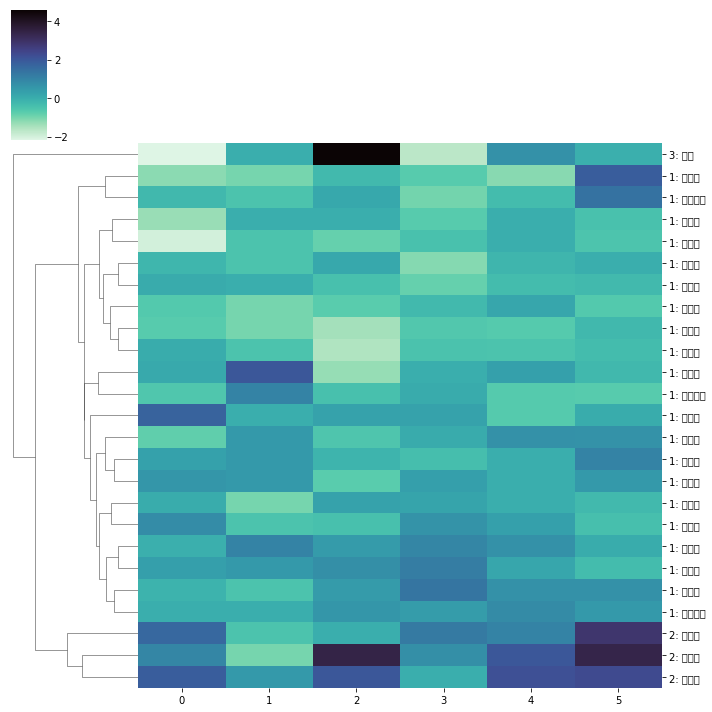

In [65]:
memb = fcluster(linkage(g_n, 'average'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='average', col_cluster=False,  cmap="mako_r")
plt.show()

In [66]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 2 :  강남구, 강서구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,-0.183112,-0.047619,-0.278912,-0.054471,-0.031746,0.107833
2,1.481115,-0.333333,1.809524,0.649880,1.722222,2.844723
3,-2.152201,0.000000,4.571429,-1.705036,0.666667,-0.026619


##### 3-4 centroid

In [67]:
g_n = goo_norm.copy()

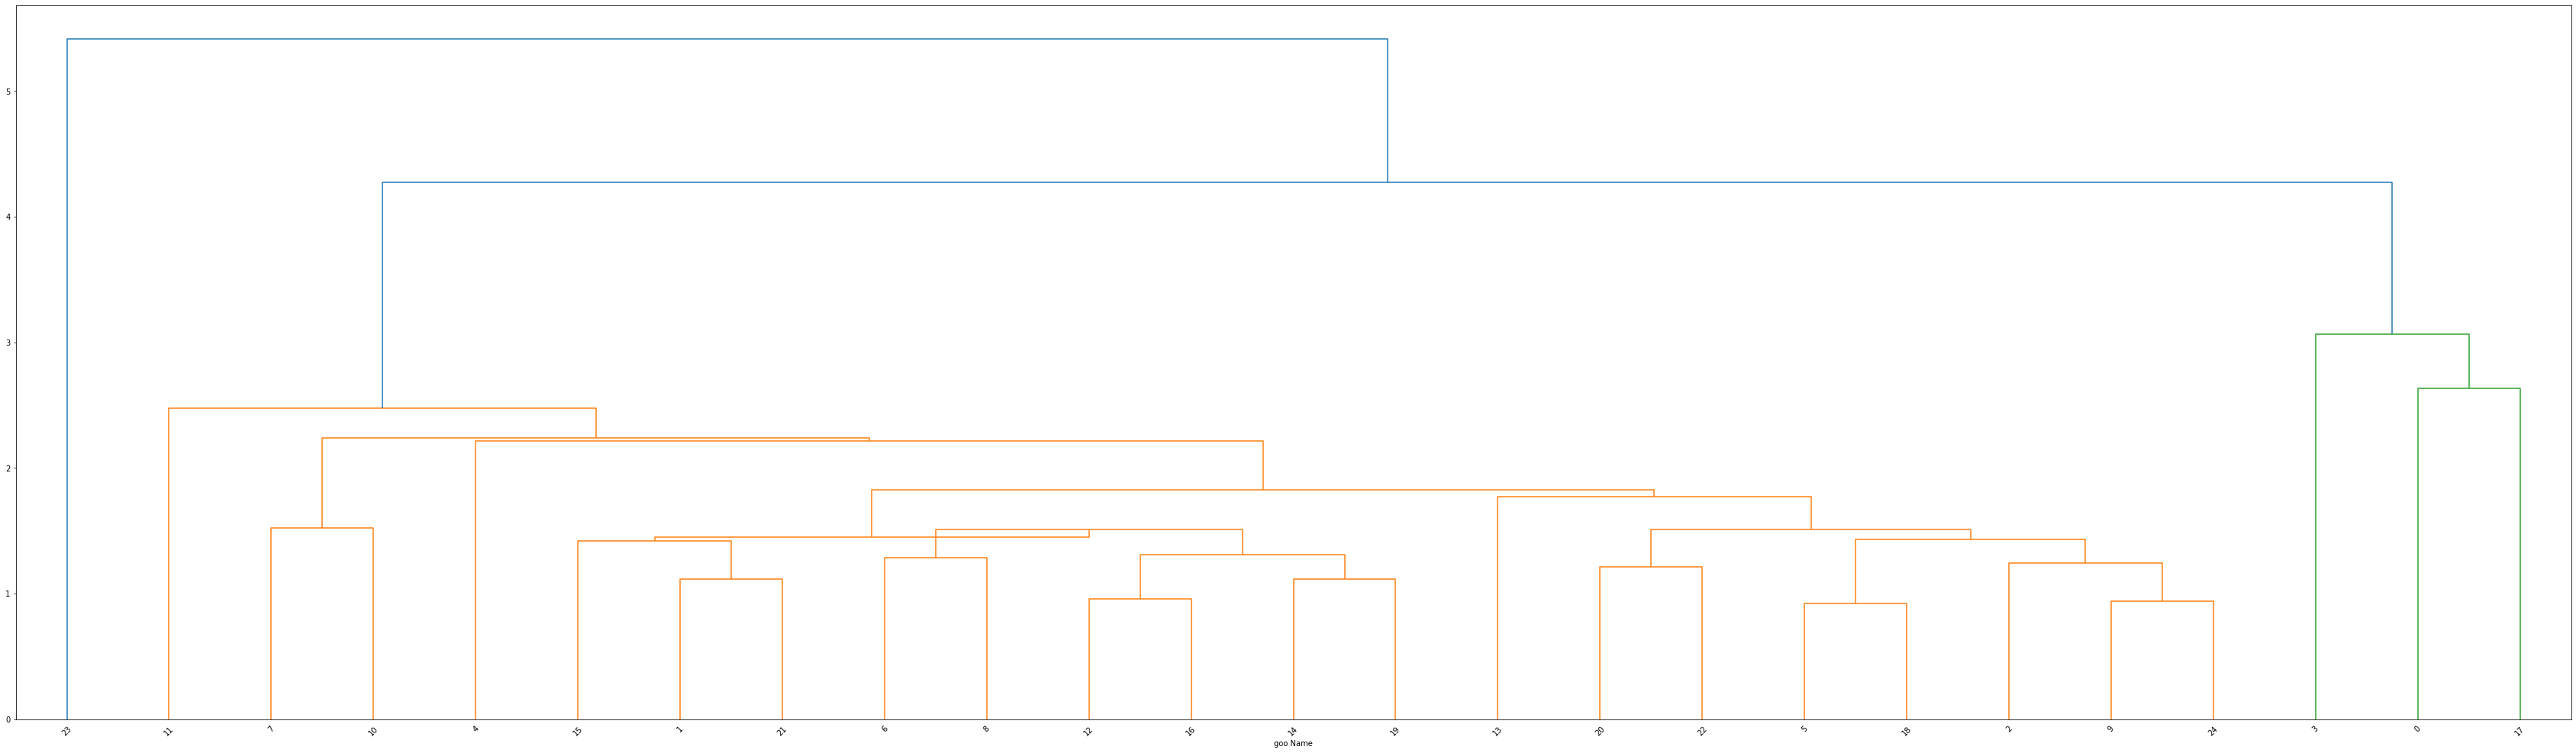

In [68]:
# 덴드로그램

Z = linkage(g_n, method='centroid') 

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

plt.title('')  # 계층적 군집화를 실행하는 덴드로그램
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강동구, 강북구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중랑구
2 :  강남구, 강서구, 송파구
3 :  중구


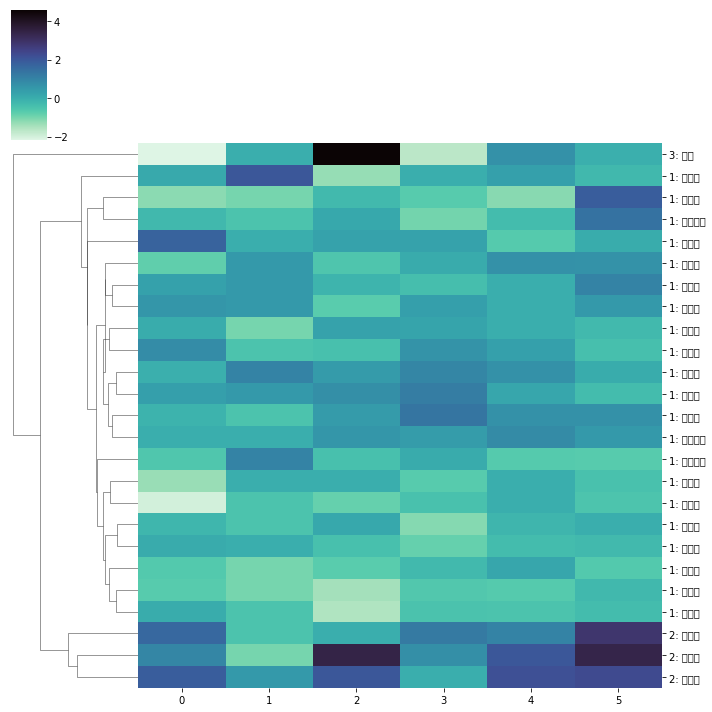

In [69]:
memb = fcluster(linkage(g_n, 'centroid'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='centroid', col_cluster=False,  cmap="mako_r")
plt.show()

In [70]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 2 :  강남구, 강서구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,-0.183112,-0.047619,-0.278912,-0.054471,-0.031746,0.107833
2,1.481115,-0.333333,1.809524,0.649880,1.722222,2.844723
3,-2.152201,0.000000,4.571429,-1.705036,0.666667,-0.026619


##### 3-5 ward

In [71]:
g_n = goo_norm.copy()

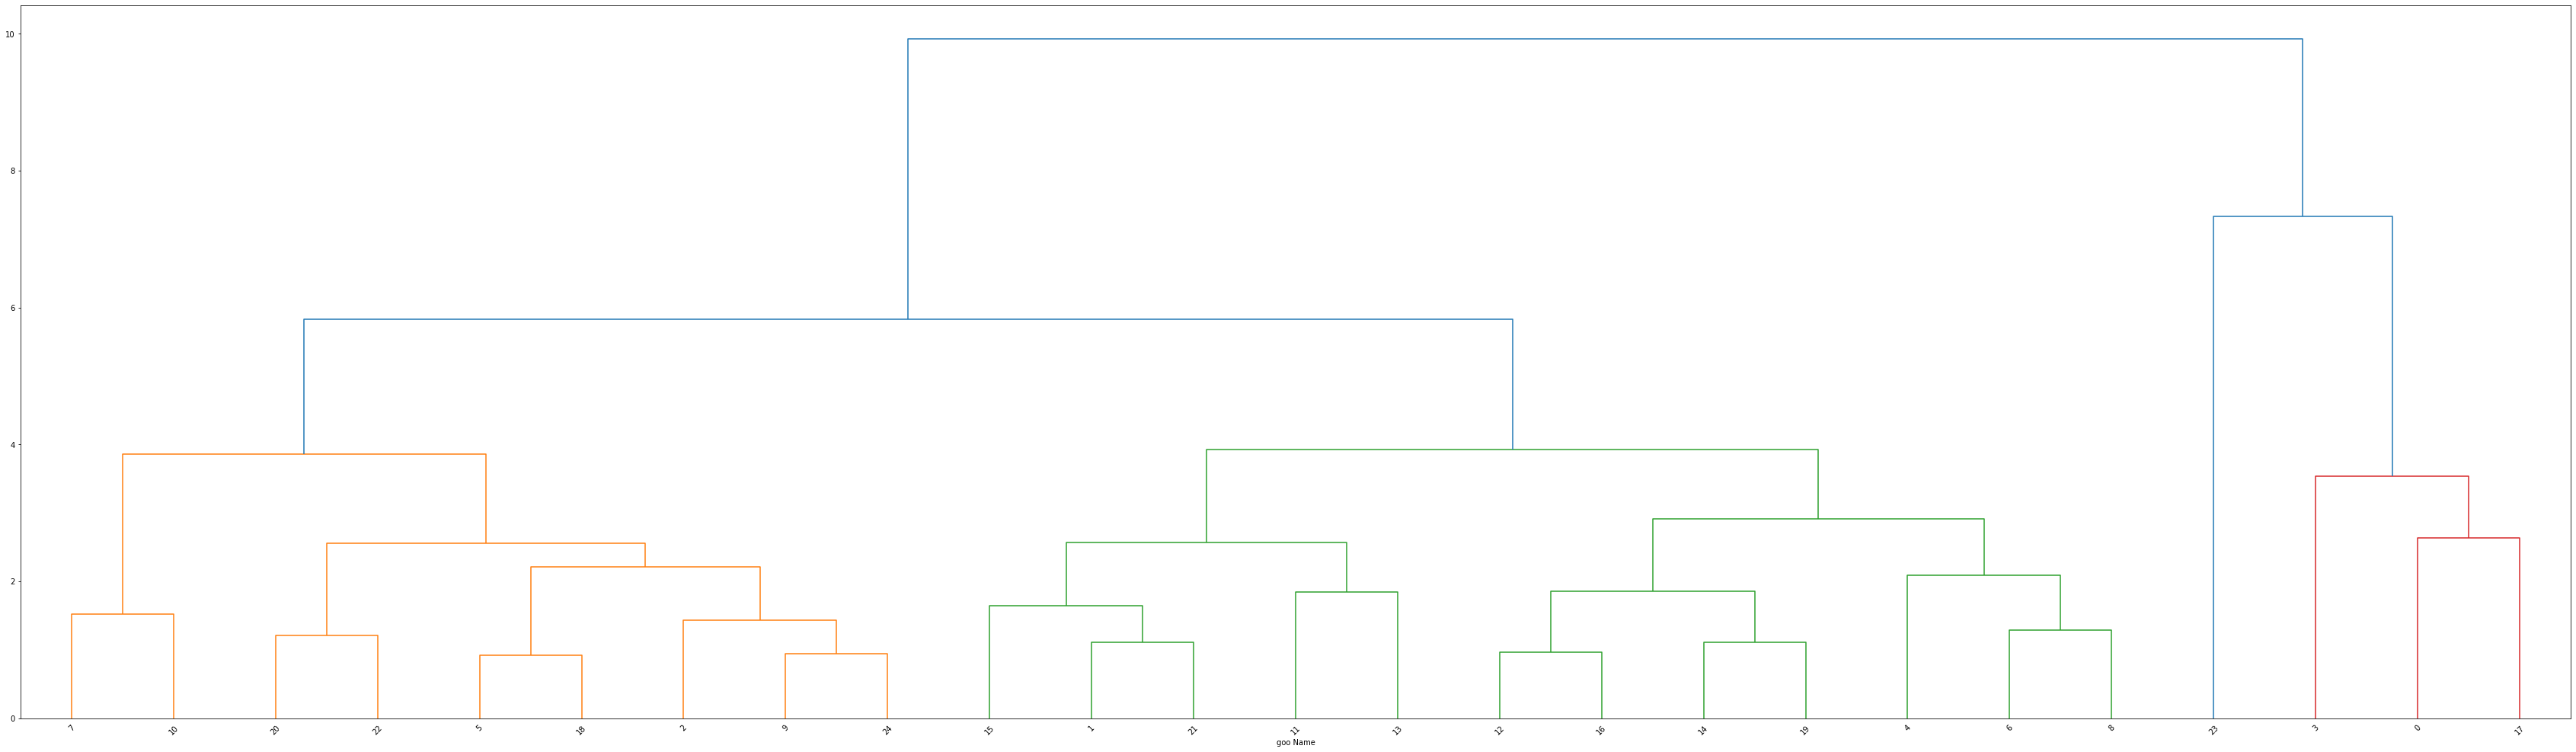

In [72]:
# 덴드로그램

Z = linkage(g_n, method='ward') 

fig = plt.figure(figsize=(60, 20))
fig.subplots_adjust(bottom=0.23)

plt.title('')  # 계층적 군집화를 실행하는 덴드로그램
plt.xlabel("goo Name")

dendrogram(Z, color_threshold = 4) # 어느 정도 수준까지를 같은 군집으로 볼 것이냐를 판단하고 시각화하는 옵션
plt.axhline(y=13, color='black', linewidth=10, linestyle='dashed')
plt.show()

1 :  강동구, 강북구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중랑구
2 :  강남구, 강서구, 송파구
3 :  중구


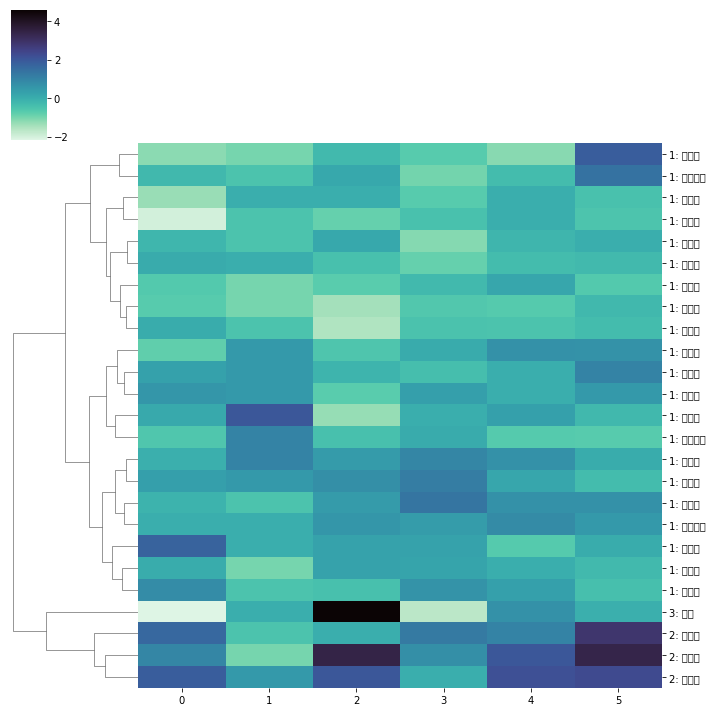

In [73]:
memb = fcluster(linkage(g_n, 'ward'), 3, criterion='maxclust')
memb = pd.Series(memb, index=g_n.index)

for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))
    

g_n.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, g_n.index)]
sns.clustermap(g_n, method='ward', col_cluster=False,  cmap="mako_r")
plt.show()

In [74]:
g_n['cluster']=[' {}'.format(i) for i,company in zip(memb, g_n.index)] # 클러스터 변수 생성
grouped = g_n.groupby('cluster')

grouped.agg('mean') # 2 :  강남구, 강서구, 송파구

,0,1,2,3,4,5
cluster,,,,,,
1,-0.183112,-0.047619,-0.278912,-0.054471,-0.031746,0.107833
2,1.481115,-0.333333,1.809524,0.649880,1.722222,2.844723
3,-2.152201,0.000000,4.571429,-1.705036,0.666667,-0.026619


# Kmeans

In [99]:
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

In [138]:
goo_df = df.copy()
goo_df = goo_df[["goo_nm","sum_hh", "count_zero", "count_market", "count_bus", "count_station", "sum_waste"]]
goo_df.set_index("goo_nm",inplace=True) # 지역구 이름 인덱싱 -> 정규화하기 위함

## 1) minmax

In [75]:
scaler = MinMaxScaler()
data = scaler.fit_transform(goo_df)
goo_norm = pd.DataFrame(data, index = list(goo_df.index))

Text(0, 0.5, 'Sum of squared distance')

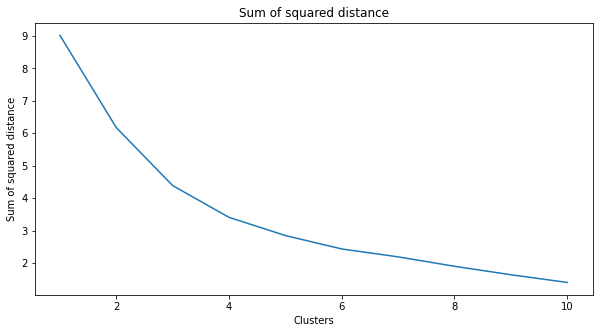

In [93]:
cluster_range = [i+1 for i in range(10)]
clus_error = []

for i in cluster_range:
    clus = KMeans(i)
    clus.fit(goo_norm)
    clus_error.append(clus.inertia_)
    
ds_error = pd.DataFrame({"NumberofCluster":cluster_range, "Error":clus_error})
plt.figure(figsize = (10,5))
plt.plot(ds_error["NumberofCluster"], ds_error["Error"])
plt.title("Sum of squared distance")
plt.xlabel("Clusters")
plt.ylabel("Sum of squared distance")

###### 2, 3, 4 모두 확인

In [94]:
#실루엣 계수 계산을 통해 최적의 군집 개수 찾기
from sklearn.metrics import pairwise
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_df = goo_df.copy()

for k in range(2,15):
    scaler = MinMaxScaler()
    scaled_sd=scaler.fit_transform(silhouette_df)
    
    kmeans=KMeans(n_clusters=k)
    clusters=kmeans.fit(scaled_sd)
    silhouette_df['cluster']=kmeans.fit_predict(scaled_sd)
    #g1['cluster']=clusters.labels_
    
    score_samples = silhouette_samples(silhouette_df, silhouette_df.cluster)
    silhouette_df['silhouette_coeff'] = score_samples
    
    average_score = silhouette_score(silhouette_df, silhouette_df.cluster)
    print('k:',k, 'score:',round(average_score,5))

k: 2 score: 0.42198
k: 3 score: 0.09104
k: 4 score: -0.00771
k: 5 score: -0.04126
k: 6 score: -0.02663
k: 7 score: -0.08732
k: 8 score: -0.15702
k: 9 score: -0.12619
k: 10 score: -0.25058
k: 11 score: -0.32539
k: 12 score: -0.42558
k: 13 score: -0.35694
k: 14 score: -0.24115


In [95]:
# k=2 ( 0.42 )

scaler = MinMaxScaler()
scaled_sd = scaler.fit_transform(goo_df)

kmeans=KMeans(n_clusters=2)
clusters=kmeans.fit(scaled_sd)
goo_df['cluster']=kmeans.fit_predict(scaled_sd)
#g1['cluster']=clusters.labels_

cluster_km_st=pd.DataFrame(kmeans.cluster_centers_)
cluster_km_st=cluster_km_st.rename(columns={0:'sum_hh',1:'count_zero',2:'count_market',3:'count_bus',4:'count_station',5:'sum_waste'})

cluster_km_st['cluster_count']=" "
for i in range(12):
    cluster_km_st['cluster_count'][i]=goo_df[goo_df['cluster']==i]['cluster'].count()

cluster_km_st.sort_values('sum_hh',ascending=False)

,sum_hh,count_zero,count_market,count_bus,count_station,sum_waste,cluster_count
0,0.902658,0.222222,0.550388,0.773838,0.866667,0.866425,3
1,0.466962,0.318182,0.246300,0.517730,0.350000,0.192984,22


In [98]:
goo_df[goo_df['cluster']==0].index

Index(['강남구', '강서구', '송파구'], dtype='object', name='goo_nm')

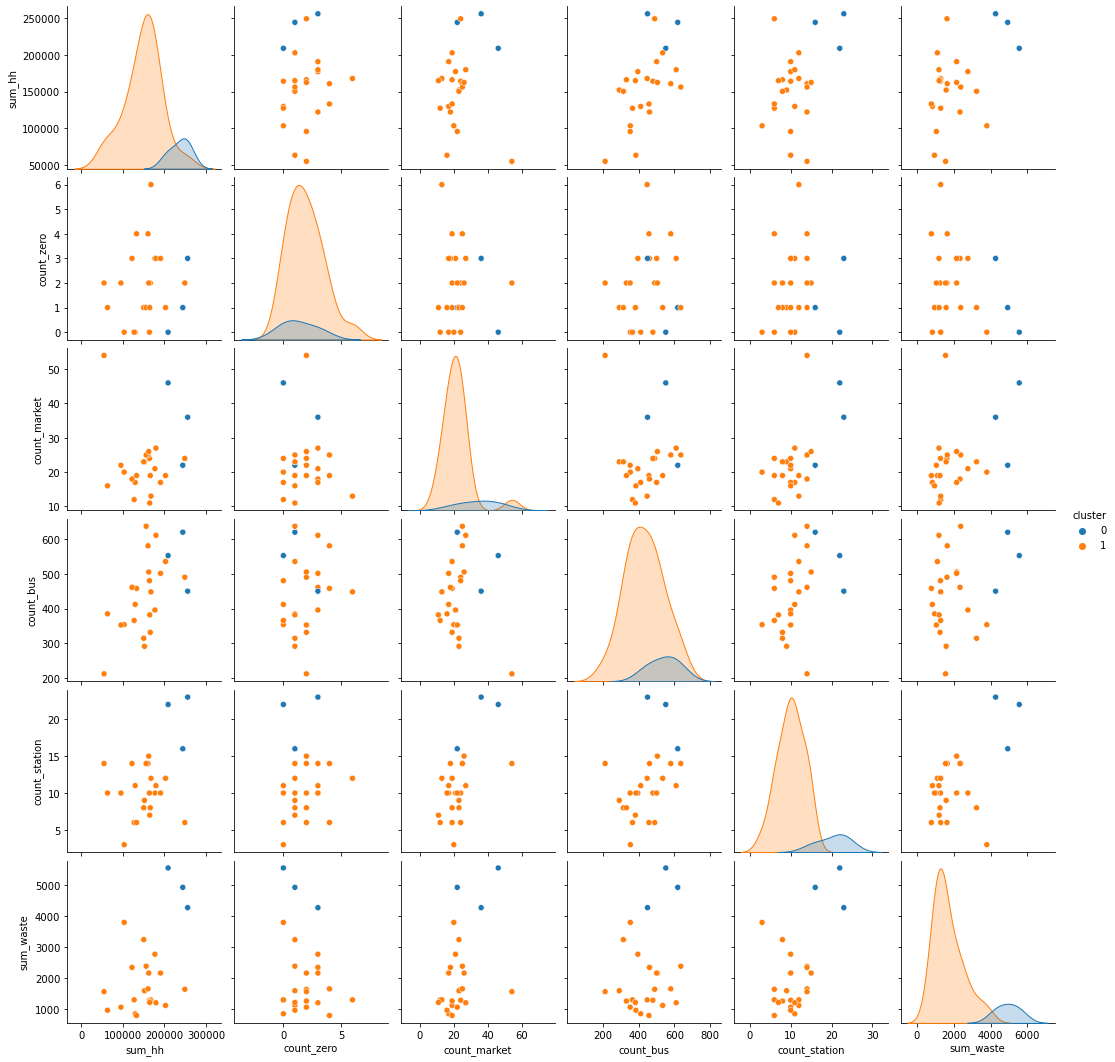

In [96]:
sns.pairplot(goo_df,hue='cluster')
plt.show()

## 2) standard

In [105]:
scaler = StandardScaler()
data = scaler.fit_transform(goo_df)
goo_norm = pd.DataFrame(data, index = list(goo_df.index))

Text(0, 0.5, 'Sum of squared distance')

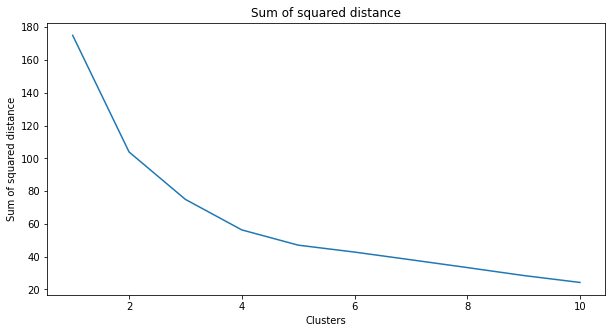

In [101]:
cluster_range = [i+1 for i in range(10)]
clus_error = []

for i in cluster_range:
    clus = KMeans(i)
    clus.fit(goo_norm)
    clus_error.append(clus.inertia_)
    
ds_error = pd.DataFrame({"NumberofCluster":cluster_range, "Error":clus_error})
plt.figure(figsize = (10,5))
plt.plot(ds_error["NumberofCluster"], ds_error["Error"])
plt.title("Sum of squared distance")
plt.xlabel("Clusters")
plt.ylabel("Sum of squared distance")

In [102]:
silhouette_df = goo_df.copy()

for k in range(2,15):
    scaler = StandardScaler()
    scaled_sd=scaler.fit_transform(silhouette_df)
    
    kmeans=KMeans(n_clusters=k)
    clusters=kmeans.fit(scaled_sd)
    silhouette_df['cluster']=kmeans.fit_predict(scaled_sd)
    #g1['cluster']=clusters.labels_
    
    score_samples = silhouette_samples(silhouette_df, silhouette_df.cluster)
    silhouette_df['silhouette_coeff'] = score_samples
    
    average_score = silhouette_score(silhouette_df, silhouette_df.cluster)
    print('k:',k, 'score:',round(average_score,5))

k: 2 score: 0.42198
k: 3 score: 0.09104
k: 4 score: -0.00771
k: 5 score: -0.04295
k: 6 score: -0.0659
k: 7 score: -0.09572
k: 8 score: -0.24528
k: 9 score: -0.28089
k: 10 score: -0.31808
k: 11 score: -0.33851
k: 12 score: -0.29976
k: 13 score: -0.29162
k: 14 score: -0.23004


In [107]:
# k=2 ( 0.42 )

scaler = StandardScaler()
scaled_sd=scaler.fit_transform(goo_df)

kmeans=KMeans(n_clusters=2)
clusters=kmeans.fit(scaled_sd)
goo_df['cluster']=kmeans.fit_predict(scaled_sd)
#g1['cluster']=clusters.labels_

cluster_km_st=pd.DataFrame(kmeans.cluster_centers_)
cluster_km_st=cluster_km_st.rename(columns={0:'sum_hh',1:'count_zero',2:'count_market',3:'count_bus',4:'count_station',5:'sum_waste'})

cluster_km_st['cluster_count']=" "
for i in range(12):
    cluster_km_st['cluster_count'][i]=goo_df[goo_df['cluster']==i]['cluster'].count()

cluster_km_st.sort_values('sum_hh',ascending=False)

,sum_hh,count_zero,count_market,count_bus,count_station,sum_waste,cluster_count
1,1.543991,-0.340482,1.208257,0.895794,1.985160,2.197198,3
0,-0.210544,0.046429,-0.164762,-0.122154,-0.270704,-0.299618,22


In [109]:
goo_df[goo_df['cluster']==1].index

Index(['강남구', '강서구', '송파구'], dtype='object', name='goo_nm')

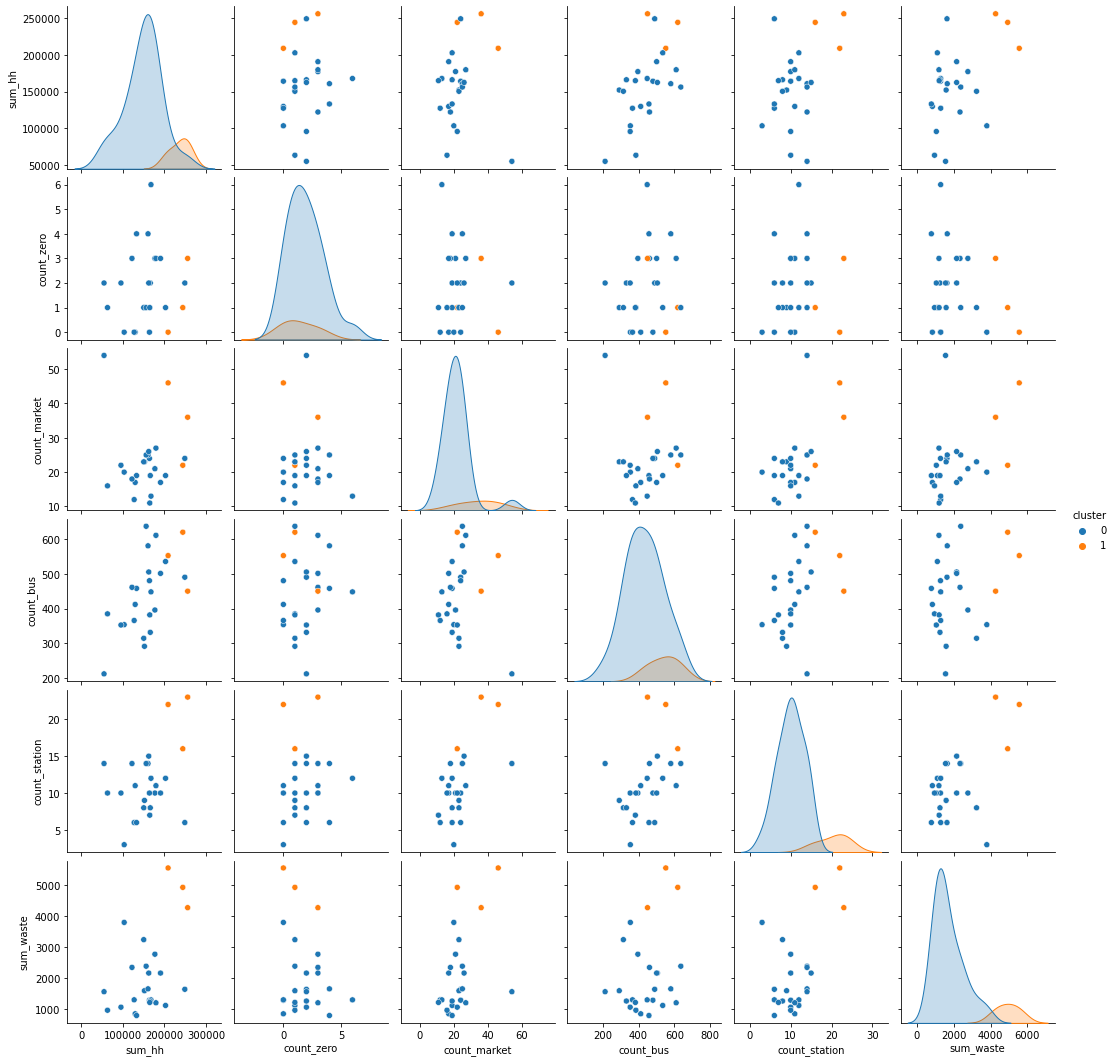

In [110]:
sns.pairplot(goo_df,hue='cluster')
plt.show()

## 3) robust

In [139]:
scaler = RobustScaler()
data = scaler.fit_transform(goo_df)
goo_norm = pd.DataFrame(data, index = list(goo_df.index))

Text(0, 0.5, 'Sum of squared distance')

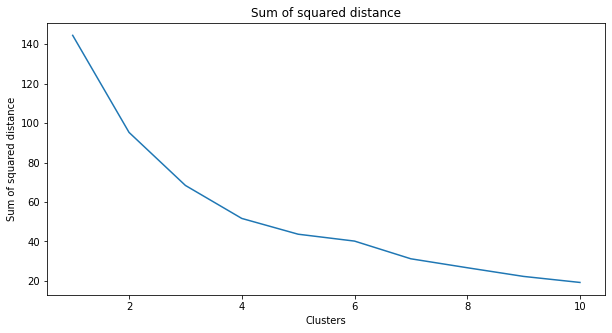

In [140]:
cluster_range = [i+1 for i in range(10)]
clus_error = []

for i in cluster_range:
    clus = KMeans(i)
    clus.fit(goo_norm)
    clus_error.append(clus.inertia_)
    
ds_error = pd.DataFrame({"NumberofCluster":cluster_range, "Error":clus_error})
plt.figure(figsize = (10,5))
plt.plot(ds_error["NumberofCluster"], ds_error["Error"])
plt.title("Sum of squared distance")
plt.xlabel("Clusters")
plt.ylabel("Sum of squared distance")

In [141]:
silhouette_df = goo_df.copy()

for k in range(2,15):
    scaler = RobustScaler()
    scaled_sd=scaler.fit_transform(silhouette_df)
    
    kmeans=KMeans(n_clusters=k)
    clusters=kmeans.fit(scaled_sd)
    silhouette_df['cluster']=kmeans.fit_predict(scaled_sd)
    #g1['cluster']=clusters.labels_
    
    score_samples = silhouette_samples(silhouette_df, silhouette_df.cluster)
    silhouette_df['silhouette_coeff'] = score_samples
    
    average_score = silhouette_score(silhouette_df, silhouette_df.cluster)
    print('k:',k, 'score:',round(average_score,5))

k: 2 score: 0.39933
k: 3 score: 0.28142
k: 4 score: -0.00771
k: 5 score: -0.08987
k: 6 score: -0.12601
k: 7 score: -0.1475
k: 8 score: -0.26242
k: 9 score: -0.31402
k: 10 score: -0.3357
k: 11 score: -0.36953
k: 12 score: -0.39501
k: 13 score: -0.38864
k: 14 score: -0.36205


In [143]:
# k: 2 score: 0.39933

scaler = RobustScaler()
scaled_sd=scaler.fit_transform(goo_df)

kmeans=KMeans(n_clusters=2)
clusters=kmeans.fit(scaled_sd)
goo_df['cluster']=kmeans.fit_predict(scaled_sd)
#g1['cluster']=clusters.labels_

cluster_km_st=pd.DataFrame(kmeans.cluster_centers_)
cluster_km_st=cluster_km_st.rename(columns={0:'sum_hh',1:'count_zero',2:'count_market',3:'count_bus',4:'count_station',5:'sum_waste'})

cluster_km_st['cluster_count']=" "
for i in range(12):
    cluster_km_st['cluster_count'][i]=goo_df[goo_df['cluster']==i]['cluster'].count()

cluster_km_st.sort_values('sum_hh',ascending=False)

,sum_hh,count_zero,count_market,count_bus,count_station,sum_waste,cluster_count
0,1.481115,-0.333333,1.809524,0.649880,1.722222e+00,2.844723,3
1,-0.272616,-0.045455,-0.058442,-0.129496,-2.775558e-17,0.101721,22


In [145]:
goo_df[goo_df['cluster']==0].index

Index(['강남구', '강서구', '송파구'], dtype='object', name='goo_nm')

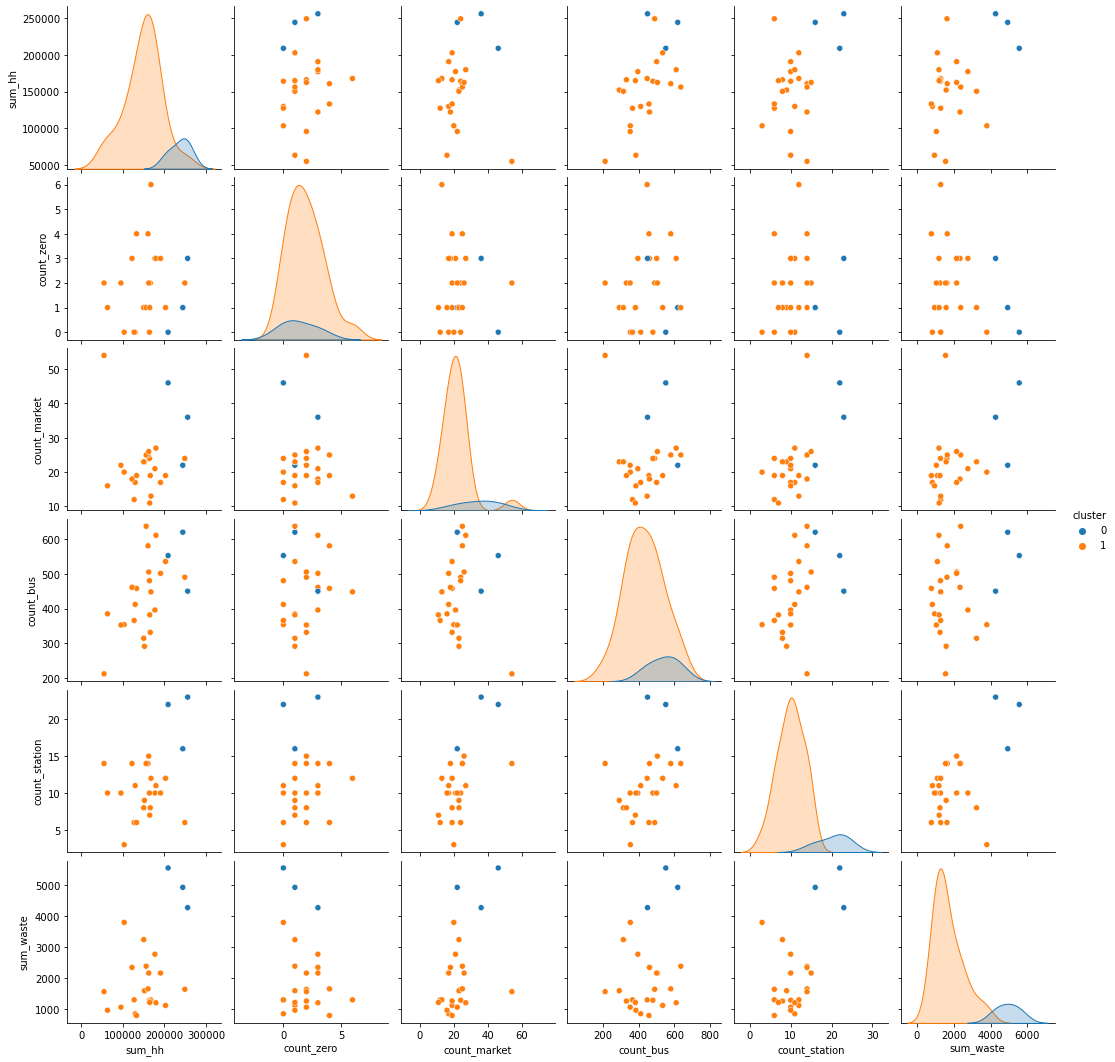

In [146]:
sns.pairplot(goo_df,hue='cluster')
plt.show()